# Advanced Manipulation Transformer - W&B Hyperparameter Sweep

This notebook implements a Weights & Biases sweep for hyperparameter optimization, focusing on:
- Augmentation parameters
- Dropout
- Learning rate scheduler
- Loss weights
- Diversity margin
- Per-joint weighting
- Fingertip weight
- Learning rate

Configuration:
- 7 epochs per run
- 20,000 training samples
- 2,000 validation samples

## 1. Environment Setup

In [1]:
# Standard imports
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import wandb
from pathlib import Path
from omegaconf import OmegaConf
import warnings
warnings.filterwarnings('ignore')

# Set environment variables
os.environ['DEX_YCB_DIR'] = '/home/n231/231nProjectV2/dex-ycb-toolkit/data'

# Add project root to path
project_root = Path('.').absolute().parent
sys.path.insert(0, str(project_root))

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

PyTorch version: 2.5.0+cu124
CUDA available: True
GPU: NVIDIA H200
GPU Memory: 139.7 GB


## 2. Define Sweep Configuration

In [2]:
# Define sweep configuration
sweep_config = {
    'method': 'bayes',  # Bayesian optimization
    'metric': {
        'name': 'val/hand_mpjpe',
        'goal': 'minimize'
    },
    'parameters': {
        # Batch size
        'batch_size': {
            'values': [32,64,128,256]
        },
        
        # Dropout
        'dropout': {
            'values': [0.1, 0.15, 0.2, 0.25, 0.3]
        },
        
        # Scheduler type
        'scheduler_type': {
            'values': ['cosine', 'cosine_warmup', 'step', 'exponential']
        },
        
        # Augmentation parameters
        'aug_rotation_range': {
            'distribution': 'uniform',
            'min': 5.0,
            'max': 15.0
        },
        'aug_scale_min': {
            'distribution': 'uniform',
            'min': 0.7,
            'max': 0.9
        },
        'aug_scale_max': {
            'distribution': 'uniform',
            'min': 1.1,
            'max': 1.3
        },
        'aug_translation_std': {
            'distribution': 'uniform',
            'min': 0.02,
            'max': 0.1
        },
        'aug_color_jitter': {
            'distribution': 'uniform',
            'min': 0.1,
            'max': 0.3
        },
        'aug_joint_noise_std': {
            'distribution': 'uniform',
            'min': 0.002,
            'max': 0.01
        },
        
        # Loss weights
        'loss_weight_hand_coarse': {
            'distribution': 'uniform',
            'min': 0.8,
            'max': 1.2
        },
        'loss_weight_hand_refined': {
            'distribution': 'uniform',
            'min': 1.0,
            'max': 1.5
        },
        'loss_weight_object_position': {
            'distribution': 'uniform',
            'min': 0.8,
            'max': 1.2
        },
        'loss_weight_object_rotation': {
            'distribution': 'uniform',
            'min': 0.3,
            'max': 0.7
        },
        'loss_weight_contact': {
            'distribution': 'uniform',
            'min': 0.2,
            'max': 0.5
        },
        'loss_weight_physics': {
            'distribution': 'uniform',
            'min': 0.05,
            'max': 0.2
        },
        'loss_weight_diversity': {
            'distribution': 'log_uniform_values',
            'min': 0.005,
            'max': 0.05
        },
        'loss_weight_reprojection': {
            'distribution': 'uniform',
            'min': 0.3,
            'max': 0.7
        },
        
        # Loss configuration
        'diversity_margin': {
            'distribution': 'uniform',
            'min': 0.005,
            'max': 0.02
        },
        'per_joint_weighting': {
            'values': [True, False]
        },
        'fingertip_weight': {
            'distribution': 'uniform',
            'min': 1.2,
            'max': 2.0
        }
    }
}

print("Sweep configuration defined:")
print(f"Method: {sweep_config['method']}")
print(f"Metric: {sweep_config['metric']['name']} ({sweep_config['metric']['goal']})")
print(f"Number of parameters: {len(sweep_config['parameters'])}")

Sweep configuration defined:
Method: bayes
Metric: val/hand_mpjpe (minimize)
Number of parameters: 20


## 3. Define Training Function

In [3]:
def train():
    # Initialize wandb
    run = wandb.init()
    
    # Load base configuration
    config = OmegaConf.load('../configs/default_config.yaml')
    
    # Override with sweep parameters
    # Learning rate, batch size, and dropout
    config.training.batch_size = wandb.config.batch_size  # Now from sweep
    config.model.dropout = wandb.config.dropout
    
    # Augmentation parameters
    config.data.augmentation.rotation_range = wandb.config.aug_rotation_range
    config.data.augmentation.scale_range = [
        wandb.config.aug_scale_min,
        wandb.config.aug_scale_max
    ]
    config.data.augmentation.translation_std = wandb.config.aug_translation_std
    config.data.augmentation.color_jitter = wandb.config.aug_color_jitter
    config.data.augmentation.joint_noise_std = wandb.config.aug_joint_noise_std
    
    # Loss weights
    config.loss.loss_weights.hand_coarse = wandb.config.loss_weight_hand_coarse
    config.loss.loss_weights.hand_refined = wandb.config.loss_weight_hand_refined
    config.loss.loss_weights.object_position = wandb.config.loss_weight_object_position
    config.loss.loss_weights.object_rotation = wandb.config.loss_weight_object_rotation
    config.loss.loss_weights.contact = wandb.config.loss_weight_contact
    config.loss.loss_weights.physics = wandb.config.loss_weight_physics
    config.loss.loss_weights.diversity = wandb.config.loss_weight_diversity
    config.loss.loss_weights.reprojection = wandb.config.loss_weight_reprojection
    
    # Loss configuration
    config.loss.diversity_margin = wandb.config.diversity_margin
    config.loss.per_joint_weighting = wandb.config.per_joint_weighting
    config.loss.fingertip_weight = wandb.config.fingertip_weight
    
    # Fixed parameters for sweep
    config.training.num_epochs = 7  # Fixed at 7 epochs
    config.training.use_wandb = True
    config.training.use_amp = True
    config.training.use_bf16 = True
    
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Import components
    from models.unified_model import UnifiedManipulationTransformer
    from training.losses import ComprehensiveLoss
    from data.gpu_cached_dataset import create_gpu_cached_dataloaders
    from solutions.mode_collapse import ModeCollapsePreventionModule
    from optimizations.pytorch_native_optimization import PyTorchNativeOptimizer
    
    try:
        # Create GPU-cached dataloaders with fixed sizes
        print(f"Creating dataloaders with 20k train, 2k val samples, batch_size={config.training.batch_size}...")
        gpu_config = {
            'gpu_max_samples': 20000,      # Fixed at 20k
            'gpu_max_samples_val': 2000,   # Fixed at 2k
            'gpu_cache_path': './gpu_cache_sweep',
            'batch_size': config.training.batch_size,  # Now using sweep parameter
            'use_bfloat16': config.training.use_bf16,
            'preload_dinov2': False
        }
        
        train_loader, val_loader = create_gpu_cached_dataloaders(gpu_config)
        print(f"Dataloaders created: {len(train_loader)} train batches, {len(val_loader)} val batches")
        
        # Create model
        model = UnifiedManipulationTransformer(config.model)
        
        # Apply mode collapse prevention
        mode_collapse_config = {
            'noise_std': 0.01,
            'drop_path_rate': 0.1,
            'mixup_alpha': 0.2
        }
        model = ModeCollapsePreventionModule.wrap_model(model, mode_collapse_config)
        
        # Initialize weights
        def init_weights(module):
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                if hasattr(module, 'weight') and module.weight is not None:
                    nn.init.xavier_uniform_(module.weight)
                if hasattr(module, 'bias') and module.bias is not None:
                    nn.init.constant_(module.bias, 0.01)
        
        for name, module in model.named_modules():
            if 'dinov2' not in name or 'encoder.layer.' not in name:
                init_weights(module)
        
        # Apply optimizations (DISABLE torch.compile to avoid errors)
        native_optimizer = PyTorchNativeOptimizer()
        model = native_optimizer.optimize_model(model, {'use_compile': False})
        model = model.to(device)
        
        # Create optimizer with parameter groups
        dinov2_params = []
        encoder_params = []
        decoder_params = []
        other_params = []
        
        for name, param in model.named_parameters():
            if not param.requires_grad:
                continue
            if 'dinov2' in name:
                dinov2_params.append(param)
            elif 'decoder' in name:
                decoder_params.append(param)
            elif 'encoder' in name:
                encoder_params.append(param)
            else:
                other_params.append(param)
        
        param_groups = []
        if dinov2_params:
            param_groups.append({
                'params': dinov2_params,
                'lr': config.training.learning_rate * 0.01,
                'name': 'dinov2'
            })
        if encoder_params:
            param_groups.append({
                'params': encoder_params,
                'lr': config.training.learning_rate * 0.5,
                'name': 'encoders'
            })
        if decoder_params:
            param_groups.append({
                'params': decoder_params,
                'lr': config.training.learning_rate,
                'name': 'decoders'
            })
        if other_params:
            param_groups.append({
                'params': other_params,
                'lr': config.training.learning_rate,
                'name': 'other'
            })
        
        optimizer = torch.optim.AdamW(param_groups, weight_decay=0.01, fused=True)
        
        # Create scheduler based on sweep parameter
        scheduler_type = wandb.config.scheduler_type
        if scheduler_type == 'cosine':
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, T_max=config.training.num_epochs, eta_min=1e-6
            )
        elif scheduler_type == 'cosine_warmup':
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=10, T_mult=2, eta_min=1e-6
            )
        elif scheduler_type == 'step':
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer, step_size=3, gamma=0.5
            )
        elif scheduler_type == 'exponential':
            scheduler = torch.optim.lr_scheduler.ExponentialLR(
                optimizer, gamma=0.9
            )
        
        # Loss function
        criterion = ComprehensiveLoss(config.loss)
        
        # Training loop
        best_val_mpjpe = float('inf')
        
        for epoch in range(config.training.num_epochs):
            # Update loss epoch
            criterion.set_epoch(epoch)
            
            # Train
            model.train()
            train_loss = 0
            train_mpjpe = 0
            train_samples = 0
            
            for batch_idx, batch in enumerate(train_loader):
                # Convert BFloat16 images to Float32 for DINOv2
                if batch['image'].dtype == torch.bfloat16:
                    batch['image'] = batch['image'].float()
                
                optimizer.zero_grad()
                
                # Forward pass
                with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                    outputs = model(batch)
                    losses = criterion(outputs, batch)
                    loss = losses['total'] if isinstance(losses, dict) else losses
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                
                batch_size = batch['image'].shape[0]
                train_loss += loss.item() * batch_size
                train_samples += batch_size
                
                # Calculate MPJPE
                if 'hand_joints' in outputs and 'hand_joints' in batch:
                    with torch.no_grad():
                        mpjpe = torch.norm(outputs['hand_joints'] - batch['hand_joints'], dim=-1).mean()
                        train_mpjpe += mpjpe.item() * 1000 * batch_size
                
                # Log batch metrics
                if batch_idx % 20 == 0:
                    wandb.log({
                        'train/batch_loss': loss.item(),
                        'train/batch_mpjpe': mpjpe.item() * 1000 if 'hand_joints' in outputs else 0,
                        'train/lr': optimizer.param_groups[0]['lr'],
                        'system/gpu_memory_gb': torch.cuda.memory_allocated() / 1e9
                    })
            
            # Average training metrics
            train_loss /= train_samples
            train_mpjpe /= train_samples
            
            # Validation
            model.eval()
            val_loss = 0
            val_mpjpe = 0
            val_samples = 0
            
            with torch.no_grad():
                for batch in val_loader:
                    if batch['image'].dtype == torch.bfloat16:
                        batch['image'] = batch['image'].float()
                    
                    with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                        outputs = model(batch)
                        losses = criterion(outputs, batch)
                        loss = losses['total'] if isinstance(losses, dict) else losses
                    
                    batch_size = batch['image'].shape[0]
                    val_samples += batch_size
                    val_loss += loss.item() * batch_size
                    
                    if 'hand_joints' in outputs and 'hand_joints' in batch:
                        mpjpe = torch.norm(outputs['hand_joints'] - batch['hand_joints'], dim=-1).mean()
                        val_mpjpe += mpjpe.item() * 1000 * batch_size
            
            # Average validation metrics
            val_loss /= val_samples
            val_mpjpe /= val_samples
            
            # Update best
            if val_mpjpe < best_val_mpjpe:
                best_val_mpjpe = val_mpjpe
            
            # Update scheduler
            scheduler.step()
            
            # Log epoch metrics
            wandb.log({
                'epoch': epoch,
                'train/loss': train_loss,
                'train/hand_mpjpe': train_mpjpe,
                'val/loss': val_loss,
                'val/hand_mpjpe': val_mpjpe,
                'val/best_mpjpe': best_val_mpjpe
            })
            
            print(f"Epoch {epoch+1}/{config.training.num_epochs}: "
                  f"train_loss={train_loss:.4f}, train_mpjpe={train_mpjpe:.2f}mm, "
                  f"val_loss={val_loss:.4f}, val_mpjpe={val_mpjpe:.2f}mm")
        
        # Log final metrics
        wandb.log({
            'final/best_val_mpjpe': best_val_mpjpe,
            'final/epochs_trained': config.training.num_epochs
        })
        
        # Clean up
        torch.cuda.empty_cache()
        
    except Exception as e:
        print(f"Training failed: {e}")
        wandb.log({'error': str(e), 'val/hand_mpjpe': 1000.0})
        raise

print("Training function defined!")

Training function defined!


## 4. Initialize and Run Sweep

In [4]:
# Initialize sweep
project_name = 'amt-hyperparameter-sweep'
sweep_id = wandb.sweep(sweep_config, project=project_name)

print(f"Sweep initialized!")
print(f"Sweep ID: {sweep_id}")
print(f"View at: https://wandb.ai/{wandb.api.default_entity}/{project_name}/sweeps/{sweep_id}")

Create sweep with ID: c189gpt8
Sweep URL: https://wandb.ai/bryandong24-stanford-university/amt-hyperparameter-sweep/sweeps/c189gpt8
Sweep initialized!
Sweep ID: c189gpt8
View at: https://wandb.ai/bryandong24-stanford-university/amt-hyperparameter-sweep/sweeps/c189gpt8


In [5]:
# Run sweep agent
# You can adjust count to run more or fewer experiments
sweep_count = 50  # Number of experiments to run

print(f"Starting sweep agent to run {sweep_count} experiments...")
print("Each experiment will run for 7 epochs with 20k training samples")
print("This will take approximately 10-15 minutes per experiment")

wandb.agent(sweep_id, function=train, count=sweep_count)

Starting sweep agent to run 50 experiments...
Each experiment will run for 7 epochs with 20k training samples
This will take approximately 10-15 minutes per experiment


wandb: Agent Starting Run: r6vq59sk with config:
wandb: 	aug_color_jitter: 0.14188335226579915
wandb: 	aug_joint_noise_std: 0.007085224723083008
wandb: 	aug_rotation_range: 6.962783046595767
wandb: 	aug_scale_max: 1.1099393612003243
wandb: 	aug_scale_min: 0.7989127002318099
wandb: 	aug_translation_std: 0.06213760246029974
wandb: 	batch_size: 32
wandb: 	diversity_margin: 0.019261430654951252
wandb: 	dropout: 0.15
wandb: 	fingertip_weight: 1.292593617054689
wandb: 	loss_weight_contact: 0.484657562364074
wandb: 	loss_weight_diversity: 0.032871346178819774
wandb: 	loss_weight_hand_coarse: 1.0946386135846584
wandb: 	loss_weight_hand_refined: 1.2476550127700048
wandb: 	loss_weight_object_position: 0.9881150050882892
wandb: 	loss_weight_object_rotation: 0.5889662368565898
wandb: 	loss_weight_physics: 0.10260366176205896
wandb: 	loss_weight_reprojection: 0.3649749315062255
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: cosine_warmup
wandb: Currently logged in as: bryandong24 (bryand

Creating dataloaders with 20k train, 2k val samples, batch_size=32...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.6 GB)
  Val: 2000 samples (6.6 GB)
  Total GPU memory: 13.3 GB
Dataloaders created: 625 train batches, 63 val batches
Epoch 1/7: train_loss=0.7255, train_mpjpe=410.26mm, val_loss=0.4841, val_mpjpe=290.33mm
Epoch 2/7: train_loss=0.5428, train_mpjpe=330.70mm, val_loss=0.4357, val_mpjpe=297.22mm
Epoch 3/7: train_loss=0.5254, train_mpjpe=308.93mm, val_loss=0.4282, val_mpjpe=262.95mm
Epoch 4/7: train_loss=0.5141, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▃▄█▂▃▂▄▃▂▃▄▄▂▃▂▅▅▄▂▂▅▁▄▅▅▄▃▃▄▄▅▂▅▂▃▃▄▂▂▂
train/batch_loss,█▃▄▃▃▂▃▃▃▃▃▃▃▂▃▂▃▂▂▂▂▄▂▁▂▂▂▃▁▃▃▃▂▂▂▁▂▃▂▂
train/batch_mpjpe,▄▅▇▇▅▆▇█▄▆▅▄▃▂▄▄▇▄▅▃▃▄▆▃▅▃▄▃▃▆▆▅▄▃▁▅▁▃▃▄
train/hand_mpjpe,█▄▃▃▂▁▁
train/loss,█▂▂▁▁▁▁
train/lr,███████████▇▇▇▇▆▆▆▆▆▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▁▁
val/best_mpjpe,██▄▃▂▁▁
val/hand_mpjpe,▇█▄▃▂▁▁


wandb: Agent Starting Run: omrwtk7b with config:
wandb: 	aug_color_jitter: 0.1449052490130817
wandb: 	aug_joint_noise_std: 0.00955584331846443
wandb: 	aug_rotation_range: 10.212810064140603
wandb: 	aug_scale_max: 1.144274821132957
wandb: 	aug_scale_min: 0.753690783503748
wandb: 	aug_translation_std: 0.05619827428649039
wandb: 	batch_size: 256
wandb: 	diversity_margin: 0.011567638693956196
wandb: 	dropout: 0.15
wandb: 	fingertip_weight: 1.2429025767362083
wandb: 	loss_weight_contact: 0.2643507025617057
wandb: 	loss_weight_diversity: 0.04584966556198141
wandb: 	loss_weight_hand_coarse: 1.1218596280914097
wandb: 	loss_weight_hand_refined: 1.121531279533072
wandb: 	loss_weight_object_position: 0.8259477838691784
wandb: 	loss_weight_object_rotation: 0.52568248511679
wandb: 	loss_weight_physics: 0.09871011681611892
wandb: 	loss_weight_reprojection: 0.6837470989989636
wandb: 	per_joint_weighting: False
wandb: 	scheduler_type: cosine


Creating dataloaders with 20k train, 2k val samples, batch_size=256...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 78 train batches, 8 val batches
Epoch 1/7: train_loss=1.4568, train_mpjpe=639.50mm, val_loss=0.8670, val_mpjpe=329.67mm
Epoch 2/7: train_loss=0.8038, train_mpjpe=395.01mm, val_loss=0.5237, val_mpjpe=311.38mm
Epoch 3/7: train_loss=0.6267, train_mpjpe=362.03mm, val_loss=0.4503, val_mpjpe=298.67mm
Epoch 4/7: train_loss=0.5973, train_mpjpe

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▅▅▄▆█▁▅▄▆▂▄▃▆█▅▄▄▆▃▃▆▁▇▅▆▅▂▃
train/batch_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch_mpjpe,█▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▃▃▂▂▁▁
train/loss,█▃▁▁▁▁▁
train/lr,████████▇▇▇▇▅▅▅▅▃▃▃▃▂▂▂▂▁▁▁▁
val/best_mpjpe,█▆▅▅▃▁▁
val/hand_mpjpe,█▆▅▅▃▁▁


wandb: Agent Starting Run: 0lpbvj2o with config:
wandb: 	aug_color_jitter: 0.252811498362129
wandb: 	aug_joint_noise_std: 0.005845042607027987
wandb: 	aug_rotation_range: 8.196033817484096
wandb: 	aug_scale_max: 1.17457148369831
wandb: 	aug_scale_min: 0.8968418285007773
wandb: 	aug_translation_std: 0.03871014363638063
wandb: 	batch_size: 32
wandb: 	diversity_margin: 0.018158201024824672
wandb: 	dropout: 0.3
wandb: 	fingertip_weight: 1.51136983309714
wandb: 	loss_weight_contact: 0.3702389758601501
wandb: 	loss_weight_diversity: 0.025457487190665744
wandb: 	loss_weight_hand_coarse: 1.1575365448892314
wandb: 	loss_weight_hand_refined: 1.3692677988047055
wandb: 	loss_weight_object_position: 1.153359724517229
wandb: 	loss_weight_object_rotation: 0.5737631208294376
wandb: 	loss_weight_physics: 0.18158911700618596
wandb: 	loss_weight_reprojection: 0.5173296475532774
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: exponential


Creating dataloaders with 20k train, 2k val samples, batch_size=32...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 625 train batches, 63 val batches
Epoch 1/7: train_loss=0.8470, train_mpjpe=414.05mm, val_loss=0.4668, val_mpjpe=300.04mm
Epoch 2/7: train_loss=0.6212, train_mpjpe=340.05mm, val_loss=0.4712, val_mpjpe=291.32mm
Epoch 3/7: train_loss=0.5765, train_mpjpe=324.44mm, val_loss=0.4817, val_mpjpe=286.98mm
Epoch 4/7: train_loss=0.5645, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,█▂▆▅▃▃▄▂▃▃▄▃▂▂▃▃▇▄▄▄▃▄▄▄▄▅▆▅▄▁▂▇▅▃▂▄▃▃▆▅
train/batch_loss,█▄█▂▃▄▅▃▄▄▃▃▄▂▁▃▁▂▁▄▄▄▄▃▁▄▅▂▂▂▁▄▃▃▂▃▃▃▃▁
train/batch_mpjpe,▇▄▄▄▃▃█▅▃▃▄▂█▂▂▆▄▃▃▅▁▄▄▄▄▃▄▄▆▄▄▅▅▅▂▁▆▂▁▃
train/hand_mpjpe,█▄▃▂▂▁▁
train/loss,█▂▁▁▁▁▁
train/lr,██████▇▇▇▇▇▅▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
val/best_mpjpe,█▆▆▃▃▂▁
val/hand_mpjpe,█▆▆▃▄▂▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9exx8uws with config:
wandb: 	aug_color_jitter: 0.2879523577596116
wandb: 	aug_joint_noise_std: 0.00822804822376846
wandb: 	aug_rotation_range: 9.184097849199803
wandb: 	aug_scale_max: 1.1072550495497968
wandb: 	aug_scale_min: 0.7469491887998319
wandb: 	aug_translation_std: 0.0371719964601423
wandb: 	batch_size: 32
wandb: 	diversity_margin: 0.018035098338995494
wandb: 	dropout: 0.15
wandb: 	fingertip_weight: 1.2428021098330106
wandb: 	loss_weight_contact: 0.39049442153868663
wandb: 	loss_weight_diversity: 0.023513173244279345
wandb: 	loss_weight_hand_coarse: 0.9395566648687508
wandb: 	loss_weight_hand_refined: 1.2196231347048188
wandb: 	loss_weight_object_position: 0.9265276541340236
wandb: 	loss_weight_object_rotation: 0.581969835465854
wandb: 	loss_weight_physics: 0.06306351996040216
wandb: 	loss_weight_reprojection: 0.3803133793341006
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: step


Creating dataloaders with 20k train, 2k val samples, batch_size=32...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 625 train batches, 63 val batches
Epoch 1/7: train_loss=0.6883, train_mpjpe=426.75mm, val_loss=0.3855, val_mpjpe=284.64mm
Epoch 2/7: train_loss=0.4810, train_mpjpe=327.85mm, val_loss=0.3936, val_mpjpe=309.80mm
Epoch 3/7: train_loss=0.4645, train_mpjpe=305.17mm, val_loss=0.4035, val_mpjpe=297.37mm
Epoch 4/7: train_loss=0.4484, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▆▃▅█▃▆▄▇▁▂▂▇▇▃▂▂▃▇▃▇▂▅▃▅▆▇▂▅▂▇█▁▅▂▆▇▃█▃▁
train/batch_loss,█▃▃▂▂▁▁▂▁▁▁▂▂▁▂▂▁▁▁▁▁▁▂▁▁▁▂▁▂▂▂▃▂▁▂▁▁▁▂▁
train/batch_mpjpe,█▅▃▅▅▅▄▄▃▆▃▄▅▅▅▅▅▅▂▃▃▂▆▅▆▄▃▁▅▄█▄▃▇▄▂▄▁█▃
train/hand_mpjpe,█▄▃▂▂▂▁
train/loss,█▂▂▁▁▁▁
train/lr,███████████████████▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁
val/best_mpjpe,███▂▂▁▁
val/hand_mpjpe,▅█▇▂▂▁▂


wandb: Agent Starting Run: p4iyh200 with config:
wandb: 	aug_color_jitter: 0.11504702066331096
wandb: 	aug_joint_noise_std: 0.0055993287300841205
wandb: 	aug_rotation_range: 6.581279785692407
wandb: 	aug_scale_max: 1.1338416299628549
wandb: 	aug_scale_min: 0.8147863005123761
wandb: 	aug_translation_std: 0.03509650116087688
wandb: 	batch_size: 32
wandb: 	diversity_margin: 0.018037990236533658
wandb: 	dropout: 0.25
wandb: 	fingertip_weight: 1.393373742571331
wandb: 	loss_weight_contact: 0.4938622021416415
wandb: 	loss_weight_diversity: 0.020514720156270365
wandb: 	loss_weight_hand_coarse: 1.0821924501763671
wandb: 	loss_weight_hand_refined: 1.2280008482420786
wandb: 	loss_weight_object_position: 0.8692240333067693
wandb: 	loss_weight_object_rotation: 0.3994449744331716
wandb: 	loss_weight_physics: 0.07483408110465048
wandb: 	loss_weight_reprojection: 0.454658984997423
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: cosine_warmup


Creating dataloaders with 20k train, 2k val samples, batch_size=32...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 625 train batches, 63 val batches
Epoch 1/7: train_loss=0.7925, train_mpjpe=436.02mm, val_loss=0.5006, val_mpjpe=299.58mm
Epoch 2/7: train_loss=0.5616, train_mpjpe=335.28mm, val_loss=0.4232, val_mpjpe=267.74mm
Epoch 3/7: train_loss=0.5266, train_mpjpe=312.84mm, val_loss=0.4227, val_mpjpe=246.97mm
Epoch 4/7: train_loss=0.5106, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,█▅▅▄▄▁▄▄▆▅▄▆▃▄▂▅▃▆▅▆▄▇▃▅▅▄▆▃▅▃▆▂▆▇▃▄▂▃▃▂
train/batch_loss,█▃▄▃▄▃▃▄▂▄▂▃▃▄▃▁▁▃▂▃▃▂▃▃▃▄▂▂▃▂▁▂▄▃▄▂▁▂▁▁
train/batch_mpjpe,▆▄█▃▃▄▂▂▄▅▅▄▂▅▄▂▂▃▄▅▄▅▄▂▄▂▃▂▂▄▂▄▁▂▂▂▃▂▂▂
train/hand_mpjpe,█▄▃▃▂▁▁
train/loss,█▃▂▁▁▁▁
train/lr,██████████▇▇▇▇▇▇▆▆▆▆▄▄▄▄▄▄▄▃▃▃▃▃▃▁▁▁▁▁▁▁
val/best_mpjpe,█▄▁▁▁▁▁
val/hand_mpjpe,█▄▁▂▂▁▁


wandb: Agent Starting Run: 9o38oquc with config:
wandb: 	aug_color_jitter: 0.1584341730348125
wandb: 	aug_joint_noise_std: 0.006910442178796531
wandb: 	aug_rotation_range: 6.982160669467106
wandb: 	aug_scale_max: 1.1609287808135182
wandb: 	aug_scale_min: 0.72773704312087
wandb: 	aug_translation_std: 0.052429586398857406
wandb: 	batch_size: 64
wandb: 	diversity_margin: 0.01508840259845217
wandb: 	dropout: 0.15
wandb: 	fingertip_weight: 1.498680936573361
wandb: 	loss_weight_contact: 0.27676710750374195
wandb: 	loss_weight_diversity: 0.02951772808898696
wandb: 	loss_weight_hand_coarse: 1.0300350549224233
wandb: 	loss_weight_hand_refined: 1.1149836753026394
wandb: 	loss_weight_object_position: 0.9534985594568716
wandb: 	loss_weight_object_rotation: 0.6298907353482276
wandb: 	loss_weight_physics: 0.10122354654178634
wandb: 	loss_weight_reprojection: 0.3811656571690656
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: cosine


Creating dataloaders with 20k train, 2k val samples, batch_size=64...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 312 train batches, 32 val batches
Epoch 1/7: train_loss=0.9481, train_mpjpe=498.75mm, val_loss=0.4037, val_mpjpe=295.81mm
Epoch 2/7: train_loss=0.5338, train_mpjpe=349.58mm, val_loss=0.4279, val_mpjpe=279.75mm
Epoch 3/7: train_loss=0.5157, train_mpjpe=322.38mm, val_loss=0.4062, val_mpjpe=266.09mm
Epoch 4/7: train_loss=0.5073, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▃▂▄▁▃▃▃▃▂▃▂▄▃▃▅▄▁▂▄▃▃▄▃▂▄▂▄▃▄▂▄▄▁▃▄▂▃▂█▄
train/batch_loss,█▃▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch_mpjpe,█▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▄▃▂▂▁▁
train/loss,█▂▁▁▁▁▁
train/lr,██████████████▇▇▇▅▅▅▅▅▃▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁
val/best_mpjpe,█▅▃▃▃▂▁
val/hand_mpjpe,█▅▃▄▃▂▁


wandb: Agent Starting Run: c43kl579 with config:
wandb: 	aug_color_jitter: 0.12672901733760675
wandb: 	aug_joint_noise_std: 0.007193260637694643
wandb: 	aug_rotation_range: 6.628984156972136
wandb: 	aug_scale_max: 1.141491857908568
wandb: 	aug_scale_min: 0.763721096146292
wandb: 	aug_translation_std: 0.04420020041596818
wandb: 	batch_size: 64
wandb: 	diversity_margin: 0.015935998751044223
wandb: 	dropout: 0.15
wandb: 	fingertip_weight: 1.2928481824627232
wandb: 	loss_weight_contact: 0.3580475031070855
wandb: 	loss_weight_diversity: 0.024383808756130564
wandb: 	loss_weight_hand_coarse: 0.9875224109515356
wandb: 	loss_weight_hand_refined: 1.1678958910650228
wandb: 	loss_weight_object_position: 1.077452397643558
wandb: 	loss_weight_object_rotation: 0.49291371329188305
wandb: 	loss_weight_physics: 0.16178025438023036
wandb: 	loss_weight_reprojection: 0.3220367553222794
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: step


Creating dataloaders with 20k train, 2k val samples, batch_size=64...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 312 train batches, 32 val batches
Epoch 1/7: train_loss=0.8764, train_mpjpe=473.25mm, val_loss=0.4148, val_mpjpe=352.02mm
Epoch 2/7: train_loss=0.5310, train_mpjpe=345.65mm, val_loss=0.4052, val_mpjpe=298.38mm
Epoch 3/7: train_loss=0.5156, train_mpjpe=326.75mm, val_loss=0.4075, val_mpjpe=277.28mm
Epoch 4/7: train_loss=0.5029, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▆▃▄▂▃▅▂▆█▅▁█▆▇▂▆▅▄▆▄▇▂▃▁▅▄▆▃▇▂▆▄█▆▄▃▅▆▅▆
train/batch_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▂▂▁▁▁▁▁▁▂▁▂▁▁▁▂▁▂▁▁▁
train/batch_mpjpe,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▄▃▂▂▁▁
train/loss,█▂▁▁▁▁▁
train/lr,████████████████████▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁
val/best_mpjpe,█▄▂▁▁▁▁
val/hand_mpjpe,█▄▂▁▁▂▂


wandb: Agent Starting Run: ywmtov8c with config:
wandb: 	aug_color_jitter: 0.28047913265426705
wandb: 	aug_joint_noise_std: 0.007263167045264424
wandb: 	aug_rotation_range: 13.475498999061012
wandb: 	aug_scale_max: 1.2115018234169104
wandb: 	aug_scale_min: 0.7873492589091858
wandb: 	aug_translation_std: 0.06799656584039776
wandb: 	batch_size: 32
wandb: 	diversity_margin: 0.010347173954799886
wandb: 	dropout: 0.15
wandb: 	fingertip_weight: 1.783179023943586
wandb: 	loss_weight_contact: 0.3283685826044055
wandb: 	loss_weight_diversity: 0.021082225320516356
wandb: 	loss_weight_hand_coarse: 1.1937766693950151
wandb: 	loss_weight_hand_refined: 1.413722881577916
wandb: 	loss_weight_object_position: 0.9159041168037446
wandb: 	loss_weight_object_rotation: 0.32339852679670056
wandb: 	loss_weight_physics: 0.1465126416273206
wandb: 	loss_weight_reprojection: 0.4637933046533785
wandb: 	per_joint_weighting: False
wandb: 	scheduler_type: cosine_warmup


Creating dataloaders with 20k train, 2k val samples, batch_size=32...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 625 train batches, 63 val batches
Epoch 1/7: train_loss=0.8175, train_mpjpe=426.15mm, val_loss=0.4668, val_mpjpe=296.39mm
Epoch 2/7: train_loss=0.5883, train_mpjpe=322.50mm, val_loss=0.4763, val_mpjpe=282.24mm
Epoch 3/7: train_loss=0.5685, train_mpjpe=301.45mm, val_loss=0.4823, val_mpjpe=273.90mm
Epoch 4/7: train_loss=0.5582, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▁▁▅▇▆▁██▅▇▆▄▃▇▅▆▆▄▄▃▅▆▇▃▇▄▇▃█▄▅▆▄▆▂▇▅▅▄▆
train/batch_loss,██▄▅▄▆▅▅▂▃▂▃▄▄▃▂▄▃▁▄▄▂▅▅▃▄▄▂▂▅▄▂▃▅▅▆▆▂▁▁
train/batch_mpjpe,▆▆▅▅▄▅▄▅▄▃▄▅▂▆▂▇▃▁▄▂▂▆▇▂▃█▄▆▄▁▅▅▄▃▅▅▆▂▁▂
train/hand_mpjpe,█▄▃▂▂▁▁
train/loss,█▃▂▂▂▁▁
train/lr,██████████▇▇▇▇▇▇▇▆▆▄▄▄▄▄▄▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁
val/best_mpjpe,█▆▅▅▄▁▁
val/hand_mpjpe,█▆▅▅▄▁▂


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: btqc5o50 with config:
wandb: 	aug_color_jitter: 0.20310943636888357
wandb: 	aug_joint_noise_std: 0.009530080013215113
wandb: 	aug_rotation_range: 8.694687715007143
wandb: 	aug_scale_max: 1.1247154511130395
wandb: 	aug_scale_min: 0.7570057832923671
wandb: 	aug_translation_std: 0.04496491425723996
wandb: 	batch_size: 32
wandb: 	diversity_margin: 0.00857742615313547
wandb: 	dropout: 0.1
wandb: 	fingertip_weight: 1.3019368741495183
wandb: 	loss_weight_contact: 0.4156766877642591
wandb: 	loss_weight_diversity: 0.008101565117471843
wandb: 	loss_weight_hand_coarse: 0.9875216759498652
wandb: 	loss_weight_hand_refined: 1.1492224929705637
wandb: 	loss_weight_object_position: 0.8535818079076642
wandb: 	loss_weight_object_rotation: 0.566843593226813
wandb: 	loss_weight_physics: 0.15398731090259948
wandb: 	loss_weight_reprojection: 0.35907058088628685
wandb: 	per_joint_weighting: False
wandb: 	scheduler_type: cosin

Creating dataloaders with 20k train, 2k val samples, batch_size=32...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 625 train batches, 63 val batches
Epoch 1/7: train_loss=0.6490, train_mpjpe=418.97mm, val_loss=0.4061, val_mpjpe=287.55mm
Epoch 2/7: train_loss=0.4789, train_mpjpe=320.12mm, val_loss=0.3889, val_mpjpe=255.45mm
Epoch 3/7: train_loss=0.4663, train_mpjpe=294.87mm, val_loss=0.3992, val_mpjpe=257.46mm
Epoch 4/7: train_loss=0.4571, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▃▅▇▂▇▇▃▆▆▅▄█▅▅▇▃▄▄▄▅▅▃▄▆▆▄▁▄▄▄▅▄▂▇▃▃▄▅▃▆
train/batch_loss,▅▅█▆▃▅▆▆▂▇▆▅█▅▄▄▃▃▃▂▄▃▅▄▃▃▂▆▅▆▁▄▃▃▂▅▆▃▃▁
train/batch_mpjpe,█▆▅▄▃▄▄▄▃▄▅▃▂▄▄▁▃▃▃▃▂▁▂▄▂▄▃▂▂▃▃▁▁▂▁▂▂▂▃▂
train/hand_mpjpe,█▄▃▃▂▁▁
train/loss,█▂▂▂▁▁▁
train/lr,██████████████▇▇▇▅▅▅▅▅▅▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
val/best_mpjpe,█▃▃▂▁▁▁
val/hand_mpjpe,█▃▃▂▁▁▁


wandb: Agent Starting Run: ayajgmmc with config:
wandb: 	aug_color_jitter: 0.1877549773583052
wandb: 	aug_joint_noise_std: 0.004255004055472966
wandb: 	aug_rotation_range: 12.726557831294022
wandb: 	aug_scale_max: 1.2915200080096316
wandb: 	aug_scale_min: 0.7692802696954715
wandb: 	aug_translation_std: 0.04761983155352275
wandb: 	batch_size: 128
wandb: 	diversity_margin: 0.01371942007734536
wandb: 	dropout: 0.1
wandb: 	fingertip_weight: 1.349628756578812
wandb: 	loss_weight_contact: 0.4974510904525554
wandb: 	loss_weight_diversity: 0.012670324760531908
wandb: 	loss_weight_hand_coarse: 0.9276159673198444
wandb: 	loss_weight_hand_refined: 1.4288977652973198
wandb: 	loss_weight_object_position: 1.1883552021513903
wandb: 	loss_weight_object_rotation: 0.45100320938167265
wandb: 	loss_weight_physics: 0.1343961967346039
wandb: 	loss_weight_reprojection: 0.55091760030526
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: cosine_warmup


Creating dataloaders with 20k train, 2k val samples, batch_size=128...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 156 train batches, 16 val batches
Epoch 1/7: train_loss=1.0253, train_mpjpe=544.08mm, val_loss=0.5027, val_mpjpe=338.99mm
Epoch 2/7: train_loss=0.5432, train_mpjpe=350.85mm, val_loss=0.4372, val_mpjpe=320.11mm
Epoch 3/7: train_loss=0.5154, train_mpjpe=324.71mm, val_loss=0.4358, val_mpjpe=282.61mm
Epoch 4/7: train_loss=0.5067, train_mpj

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▂▇▆█▃▅▅▇▆▄▃▁▆▄▄▄▆▆▃▇▄▃▅▂▃▄▃▄▄▅▃▄▅▄▆▃▄▅▅▇
train/batch_loss,█▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch_mpjpe,█▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▃▃▂▂▁▁
train/loss,█▂▁▁▁▁▁
train/lr,████████████▇▇▇▇▇▇▆▆▆▆▆▄▄▄▄▄▄▄▃▃▃▃▃▁▁▁▁▁
val/best_mpjpe,█▇▄▂▂▁▁
val/hand_mpjpe,█▇▄▂▂▁▁


wandb: Agent Starting Run: mvy5ofug with config:
wandb: 	aug_color_jitter: 0.1574345004647183
wandb: 	aug_joint_noise_std: 0.004807897503858896
wandb: 	aug_rotation_range: 11.514959575073764
wandb: 	aug_scale_max: 1.1913203512767343
wandb: 	aug_scale_min: 0.8947288380517606
wandb: 	aug_translation_std: 0.05896862338045847
wandb: 	batch_size: 256
wandb: 	diversity_margin: 0.01896999912033747
wandb: 	dropout: 0.15
wandb: 	fingertip_weight: 1.6123349913172371
wandb: 	loss_weight_contact: 0.3100556660910997
wandb: 	loss_weight_diversity: 0.026374818097572864
wandb: 	loss_weight_hand_coarse: 1.02316870798047
wandb: 	loss_weight_hand_refined: 1.1960275268693896
wandb: 	loss_weight_object_position: 0.868416682345561
wandb: 	loss_weight_object_rotation: 0.5014486182177844
wandb: 	loss_weight_physics: 0.13157367101301648
wandb: 	loss_weight_reprojection: 0.6544357557573561
wandb: 	per_joint_weighting: False
wandb: 	scheduler_type: step


Creating dataloaders with 20k train, 2k val samples, batch_size=256...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 78 train batches, 8 val batches
Epoch 1/7: train_loss=1.2851, train_mpjpe=645.93mm, val_loss=0.7037, val_mpjpe=346.91mm
Epoch 2/7: train_loss=0.7242, train_mpjpe=375.40mm, val_loss=0.4670, val_mpjpe=308.02mm
Epoch 3/7: train_loss=0.6018, train_mpjpe=347.01mm, val_loss=0.4534, val_mpjpe=298.59mm
Epoch 4/7: train_loss=0.5703, train_mpjpe

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,█▇███▁▄▅▅▅▃▃▆▄▃▅▂█▃█▃▇▅▄▂▂▃▄
train/batch_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch_mpjpe,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▃▂▂▂▁▁
train/loss,█▃▁▁▁▁▁
train/lr,████████████▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁
val/best_mpjpe,█▅▄▂▂▂▁
val/hand_mpjpe,█▅▄▂▃▂▁


wandb: Agent Starting Run: ssef33l1 with config:
wandb: 	aug_color_jitter: 0.1342150778160502
wandb: 	aug_joint_noise_std: 0.002940157585021656
wandb: 	aug_rotation_range: 5.928571892876024
wandb: 	aug_scale_max: 1.1560131350919642
wandb: 	aug_scale_min: 0.7986666051871159
wandb: 	aug_translation_std: 0.06640508942305667
wandb: 	batch_size: 256
wandb: 	diversity_margin: 0.01042839972560866
wandb: 	dropout: 0.2
wandb: 	fingertip_weight: 1.4234744897955902
wandb: 	loss_weight_contact: 0.21008130398128108
wandb: 	loss_weight_diversity: 0.03962449199323792
wandb: 	loss_weight_hand_coarse: 1.0450898319524136
wandb: 	loss_weight_hand_refined: 1.3667141075194342
wandb: 	loss_weight_object_position: 1.1947227741041662
wandb: 	loss_weight_object_rotation: 0.41525867676285416
wandb: 	loss_weight_physics: 0.06152409480606691
wandb: 	loss_weight_reprojection: 0.5838977323011864
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: exponential


Creating dataloaders with 20k train, 2k val samples, batch_size=256...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 78 train batches, 8 val batches
Epoch 1/7: train_loss=1.4256, train_mpjpe=694.31mm, val_loss=0.8699, val_mpjpe=430.66mm
Epoch 2/7: train_loss=0.8111, train_mpjpe=386.52mm, val_loss=0.5210, val_mpjpe=300.23mm
Epoch 3/7: train_loss=0.6491, train_mpjpe=350.06mm, val_loss=0.5103, val_mpjpe=300.59mm
Epoch 4/7: train_loss=0.6058, train_mpjpe

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,█▇███▁▄▅▅▅▃▃▆▄▃▅▂█▃█▃▇▅▄▂▂▃▄
train/batch_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch_mpjpe,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▃▂▂▁▁▁
train/loss,█▃▂▁▁▁▁
train/lr,████▇▇▇▇▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
val/best_mpjpe,█▃▃▂▂▁▁
val/hand_mpjpe,█▃▃▂▂▁▁


wandb: Agent Starting Run: 3dmrr3u6 with config:
wandb: 	aug_color_jitter: 0.1037060385874024
wandb: 	aug_joint_noise_std: 0.0071957051651789
wandb: 	aug_rotation_range: 5.162602694339399
wandb: 	aug_scale_max: 1.2697262123350748
wandb: 	aug_scale_min: 0.8963119986047501
wandb: 	aug_translation_std: 0.08792948927422924
wandb: 	batch_size: 128
wandb: 	diversity_margin: 0.017817668344071086
wandb: 	dropout: 0.2
wandb: 	fingertip_weight: 1.3237605093501572
wandb: 	loss_weight_contact: 0.4684896866249347
wandb: 	loss_weight_diversity: 0.03997040807630691
wandb: 	loss_weight_hand_coarse: 0.8293814991830881
wandb: 	loss_weight_hand_refined: 1.11585968578572
wandb: 	loss_weight_object_position: 0.8893006286749449
wandb: 	loss_weight_object_rotation: 0.44808259580496296
wandb: 	loss_weight_physics: 0.1296545806628827
wandb: 	loss_weight_reprojection: 0.3373697640056881
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: step


Creating dataloaders with 20k train, 2k val samples, batch_size=128...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 156 train batches, 16 val batches
Epoch 1/7: train_loss=1.0179, train_mpjpe=550.86mm, val_loss=0.5536, val_mpjpe=325.48mm
Epoch 2/7: train_loss=0.5225, train_mpjpe=361.79mm, val_loss=0.3660, val_mpjpe=332.36mm
Epoch 3/7: train_loss=0.4906, train_mpjpe=337.01mm, val_loss=0.3784, val_mpjpe=264.67mm
Epoch 4/7: train_loss=0.4687, train_mpj

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▂▂▄▇▅▃▃▅▅▃▁▁█▅▄▅▂▄▃▄▄▄▅▅▅▅▅▅▃▄▆▅▃▃▃▆▂▄▇▆
train/batch_loss,█▄▃▂▂▂▁▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▂
train/batch_mpjpe,█▂▂▂▂▂▂▂▁▁▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▃▃▂▂▁▁
train/loss,█▂▁▁▁▁▁
train/lr,███████████████████▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁
val/best_mpjpe,██▂▂▂▁▁
val/hand_mpjpe,▇█▂▂▃▁▁


wandb: Agent Starting Run: pblhrjle with config:
wandb: 	aug_color_jitter: 0.1250635199814275
wandb: 	aug_joint_noise_std: 0.00453455051278761
wandb: 	aug_rotation_range: 7.438926791997208
wandb: 	aug_scale_max: 1.2396150254054663
wandb: 	aug_scale_min: 0.7409858104505066
wandb: 	aug_translation_std: 0.06652892785539152
wandb: 	batch_size: 128
wandb: 	diversity_margin: 0.005972349258746254
wandb: 	dropout: 0.3
wandb: 	fingertip_weight: 1.2099339742716817
wandb: 	loss_weight_contact: 0.45219071791117665
wandb: 	loss_weight_diversity: 0.00519277328576154
wandb: 	loss_weight_hand_coarse: 1.0095001456355774
wandb: 	loss_weight_hand_refined: 1.314758370028681
wandb: 	loss_weight_object_position: 1.1655400525841215
wandb: 	loss_weight_object_rotation: 0.6842202711557879
wandb: 	loss_weight_physics: 0.05766427373234568
wandb: 	loss_weight_reprojection: 0.48192766985805974
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: step


Creating dataloaders with 20k train, 2k val samples, batch_size=128...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 156 train batches, 16 val batches
Epoch 1/7: train_loss=1.2279, train_mpjpe=531.31mm, val_loss=0.6049, val_mpjpe=326.66mm
Epoch 2/7: train_loss=0.6653, train_mpjpe=357.77mm, val_loss=0.5551, val_mpjpe=300.42mm
Epoch 3/7: train_loss=0.6187, train_mpjpe=333.30mm, val_loss=0.4381, val_mpjpe=285.07mm
Epoch 4/7: train_loss=0.6048, train_mpj

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▃▄▄▆▂▂▃▄▅▂▂▅▃▄▆▃▄▄▂█▄▃▄▄▂▄▂▂▃▁▄▃▄▅▄▂▄▃▇▃
train/batch_loss,█▄▂▂▂▂▂▂▁▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁
train/batch_mpjpe,█▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▃▃▂▂▁▁
train/loss,█▂▁▁▁▁▁
train/lr,████████████████▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁
val/best_mpjpe,█▆▄▃▂▁▁
val/hand_mpjpe,█▆▄▃▂▁▁


wandb: Agent Starting Run: hzeuwcec with config:
wandb: 	aug_color_jitter: 0.2243158419722358
wandb: 	aug_joint_noise_std: 0.004702267567070829
wandb: 	aug_rotation_range: 12.038978293738973
wandb: 	aug_scale_max: 1.2581937225010833
wandb: 	aug_scale_min: 0.7930900068073665
wandb: 	aug_translation_std: 0.02100359041551222
wandb: 	batch_size: 256
wandb: 	diversity_margin: 0.0069266685342013225
wandb: 	dropout: 0.3
wandb: 	fingertip_weight: 1.861392215404659
wandb: 	loss_weight_contact: 0.4869461578493837
wandb: 	loss_weight_diversity: 0.04866880211674292
wandb: 	loss_weight_hand_coarse: 0.9400985225622004
wandb: 	loss_weight_hand_refined: 1.0763452875470878
wandb: 	loss_weight_object_position: 1.0477027184828662
wandb: 	loss_weight_object_rotation: 0.5119823254798943
wandb: 	loss_weight_physics: 0.09456322267970872
wandb: 	loss_weight_reprojection: 0.6995082476175166
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: exponential


Creating dataloaders with 20k train, 2k val samples, batch_size=256...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 78 train batches, 8 val batches
Epoch 1/7: train_loss=1.3922, train_mpjpe=701.80mm, val_loss=0.9627, val_mpjpe=529.44mm
Epoch 2/7: train_loss=0.8020, train_mpjpe=411.26mm, val_loss=0.4986, val_mpjpe=322.61mm
Epoch 3/7: train_loss=0.6130, train_mpjpe=356.37mm, val_loss=0.4492, val_mpjpe=299.70mm
Epoch 4/7: train_loss=0.5898, train_mpjpe

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▄▆▇▆▄▅▃▆▄▃▂▃▅▃▂▃█▁▂▄▅▃▂▄▇▄▂▄
train/batch_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch_mpjpe,█▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▃▂▁▁▁▁
train/loss,█▃▁▁▁▁▁
train/lr,████▇▇▇▇▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
val/best_mpjpe,█▂▂▁▁▁▁
val/hand_mpjpe,█▂▂▁▁▁▁


wandb: Agent Starting Run: ze2fldb7 with config:
wandb: 	aug_color_jitter: 0.13869033859760888
wandb: 	aug_joint_noise_std: 0.0070658325482116585
wandb: 	aug_rotation_range: 7.400351206601652
wandb: 	aug_scale_max: 1.144004991073824
wandb: 	aug_scale_min: 0.8840870559114468
wandb: 	aug_translation_std: 0.0538799922962865
wandb: 	batch_size: 64
wandb: 	diversity_margin: 0.014108643734790295
wandb: 	dropout: 0.15
wandb: 	fingertip_weight: 1.8744892764382568
wandb: 	loss_weight_contact: 0.4801413350017296
wandb: 	loss_weight_diversity: 0.009402799400532692
wandb: 	loss_weight_hand_coarse: 0.8844968902540621
wandb: 	loss_weight_hand_refined: 1.2503924254052825
wandb: 	loss_weight_object_position: 0.9029843565268668
wandb: 	loss_weight_object_rotation: 0.6718094406104496
wandb: 	loss_weight_physics: 0.18583158743291184
wandb: 	loss_weight_reprojection: 0.30422200644674424
wandb: 	per_joint_weighting: False
wandb: 	scheduler_type: step


Creating dataloaders with 20k train, 2k val samples, batch_size=64...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 312 train batches, 32 val batches
Epoch 1/7: train_loss=0.7848, train_mpjpe=481.52mm, val_loss=0.4375, val_mpjpe=336.64mm
Epoch 2/7: train_loss=0.4904, train_mpjpe=347.11mm, val_loss=0.3882, val_mpjpe=312.25mm
Epoch 3/7: train_loss=0.4717, train_mpjpe=321.67mm, val_loss=0.3795, val_mpjpe=288.42mm
Epoch 4/7: train_loss=0.4599, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▆▆▄▂▂▅▅█▃▅▇▅▄▄▄▄▆▃▇▄▆▁▃▆█▄▆▁▃▃▃▇▆▆▄▄▁▃█▇
train/batch_loss,▇▆▅▄▃▃▂▄▃▃█▄▄▃▃▄▄▂▃▅▃▅▃▂▂▃▅▃▃▂▂▂▂▅▃▄▁▆▁▃
train/batch_mpjpe,█▁▂▂▂▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁
train/hand_mpjpe,█▄▃▂▂▁▁
train/loss,█▂▁▁▁▁▁
train/lr,█████████████████▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁
val/best_mpjpe,█▆▅▁▁▁▁
val/hand_mpjpe,█▆▅▁▁▁▂


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gl7i4fq3 with config:
wandb: 	aug_color_jitter: 0.24454528743473136
wandb: 	aug_joint_noise_std: 0.007932944628698639
wandb: 	aug_rotation_range: 5.71360886499428
wandb: 	aug_scale_max: 1.2433753984755511
wandb: 	aug_scale_min: 0.8396469272856542
wandb: 	aug_translation_std: 0.02581771617624308
wandb: 	batch_size: 32
wandb: 	diversity_margin: 0.011440928918859512
wandb: 	dropout: 0.25
wandb: 	fingertip_weight: 1.5299005787552664
wandb: 	loss_weight_contact: 0.4583407817395416
wandb: 	loss_weight_diversity: 0.005209688871113964
wandb: 	loss_weight_hand_coarse: 0.8376674797727754
wandb: 	loss_weight_hand_refined: 1.4443432730678134
wandb: 	loss_weight_object_position: 1.1865868505031134
wandb: 	loss_weight_object_rotation: 0.386328073309788
wandb: 	loss_weight_physics: 0.059720698353751926
wandb: 	loss_weight_reprojection: 0.6675281096059253
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: cosin

Creating dataloaders with 20k train, 2k val samples, batch_size=32...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 625 train batches, 63 val batches
Epoch 1/7: train_loss=0.6863, train_mpjpe=419.85mm, val_loss=0.4042, val_mpjpe=280.33mm
Epoch 2/7: train_loss=0.4913, train_mpjpe=326.40mm, val_loss=0.3916, val_mpjpe=273.84mm
Epoch 3/7: train_loss=0.4687, train_mpjpe=309.22mm, val_loss=0.3809, val_mpjpe=267.48mm
Epoch 4/7: train_loss=0.4588, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▄▂▂▁▅▁▂▂▄▅▇▅▂▇▅▂▄▄▄█▂▂▅▇▄▃▄▆▃▂▃▄▄▄▄▄▃▅▄▃
train/batch_loss,█▅▄▃▃▂▃▃▂▂▂▂▂▂▃▂▃▂▂▃▂▁▂▄▁▂▂▂▁▃▃▁▁▃▁▂▂▂▂▂
train/batch_mpjpe,█▂▂▁▂▂▁▂▂▁▂▁▂▁▂▁▂▁▁▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▂▁▂▁▁▁
train/hand_mpjpe,█▄▃▃▂▁▁
train/loss,█▂▁▁▁▁▁
train/lr,██████████████▇▇▇▅▅▅▅▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val/best_mpjpe,█▇▆▄▁▁▁
val/hand_mpjpe,█▇▆▄▁▁▁


wandb: Agent Starting Run: cxxeez6j with config:
wandb: 	aug_color_jitter: 0.2824843944613778
wandb: 	aug_joint_noise_std: 0.009055449757848891
wandb: 	aug_rotation_range: 8.853188678736426
wandb: 	aug_scale_max: 1.259417043331454
wandb: 	aug_scale_min: 0.735361340412327
wandb: 	aug_translation_std: 0.06038959496669635
wandb: 	batch_size: 256
wandb: 	diversity_margin: 0.019489527690526524
wandb: 	dropout: 0.2
wandb: 	fingertip_weight: 1.4058040123558029
wandb: 	loss_weight_contact: 0.4546136542267654
wandb: 	loss_weight_diversity: 0.012132865766771916
wandb: 	loss_weight_hand_coarse: 0.978614373376284
wandb: 	loss_weight_hand_refined: 1.118668837799536
wandb: 	loss_weight_object_position: 0.8019546337530047
wandb: 	loss_weight_object_rotation: 0.5731658090961085
wandb: 	loss_weight_physics: 0.12975943122892014
wandb: 	loss_weight_reprojection: 0.6288707074627253
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: step


Creating dataloaders with 20k train, 2k val samples, batch_size=256...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 78 train batches, 8 val batches
Epoch 1/7: train_loss=1.3333, train_mpjpe=651.02mm, val_loss=0.8474, val_mpjpe=319.27mm
Epoch 2/7: train_loss=0.8087, train_mpjpe=389.62mm, val_loss=0.5105, val_mpjpe=317.05mm
Epoch 3/7: train_loss=0.6216, train_mpjpe=379.91mm, val_loss=0.4313, val_mpjpe=314.50mm
Epoch 4/7: train_loss=0.5678, train_mpjpe

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▆▇█▇▆▇▃▅▄▂▅▄▅▅▁▂▃▄▃▅▅▄▄▆▆▄▄▄
train/batch_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch_mpjpe,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▂▂▁▁▁▁
train/loss,█▃▁▁▁▁▁
train/lr,████████████▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁
val/best_mpjpe,██▇▄▃▃▁
val/hand_mpjpe,██▇▄▃▄▁


wandb: Agent Starting Run: 1d03bb2p with config:
wandb: 	aug_color_jitter: 0.20141267506489152
wandb: 	aug_joint_noise_std: 0.002680439626393179
wandb: 	aug_rotation_range: 10.015607581636342
wandb: 	aug_scale_max: 1.1126150383543536
wandb: 	aug_scale_min: 0.8798647438953972
wandb: 	aug_translation_std: 0.06942049003610154
wandb: 	batch_size: 256
wandb: 	diversity_margin: 0.013418223036450422
wandb: 	dropout: 0.15
wandb: 	fingertip_weight: 1.944121609066864
wandb: 	loss_weight_contact: 0.35924868013857925
wandb: 	loss_weight_diversity: 0.007986228687405865
wandb: 	loss_weight_hand_coarse: 0.833789507603387
wandb: 	loss_weight_hand_refined: 1.0307574078126738
wandb: 	loss_weight_object_position: 0.9998394916436452
wandb: 	loss_weight_object_rotation: 0.35011009002677973
wandb: 	loss_weight_physics: 0.16867140877018613
wandb: 	loss_weight_reprojection: 0.6146398363308616
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: cosine_warmup


Creating dataloaders with 20k train, 2k val samples, batch_size=256...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 78 train batches, 8 val batches
Epoch 1/7: train_loss=1.1323, train_mpjpe=656.83mm, val_loss=0.6413, val_mpjpe=342.05mm
Epoch 2/7: train_loss=0.6321, train_mpjpe=387.60mm, val_loss=0.4206, val_mpjpe=307.62mm
Epoch 3/7: train_loss=0.5023, train_mpjpe=354.52mm, val_loss=0.3747, val_mpjpe=310.55mm
Epoch 4/7: train_loss=0.4767, train_mpjpe

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▆█▇▆▆▂▃▄▄▁▃▄▃▄▅▄▅▄▇▆█▄▃▂▆▄▄▅
train/batch_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch_mpjpe,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▃▂▂▁▁▁
train/loss,█▃▁▁▁▁▁
train/lr,████████▇▇▇▇▆▆▆▆▄▄▄▄▃▃▃▃▁▁▁▁
val/best_mpjpe,█▅▅▃▂▁▁
val/hand_mpjpe,█▅▅▃▂▁▂


wandb: Agent Starting Run: 12uzgf5n with config:
wandb: 	aug_color_jitter: 0.2638112686691605
wandb: 	aug_joint_noise_std: 0.007238275406785554
wandb: 	aug_rotation_range: 8.278427654568652
wandb: 	aug_scale_max: 1.1183825617501586
wandb: 	aug_scale_min: 0.7249008715183684
wandb: 	aug_translation_std: 0.03700274930751707
wandb: 	batch_size: 32
wandb: 	diversity_margin: 0.017392291892585433
wandb: 	dropout: 0.2
wandb: 	fingertip_weight: 1.255079489563434
wandb: 	loss_weight_contact: 0.3533773535587258
wandb: 	loss_weight_diversity: 0.01757853986681419
wandb: 	loss_weight_hand_coarse: 0.9076522081995224
wandb: 	loss_weight_hand_refined: 1.1789599094312615
wandb: 	loss_weight_object_position: 0.9767997624569592
wandb: 	loss_weight_object_rotation: 0.6618190385761621
wandb: 	loss_weight_physics: 0.06209158960194515
wandb: 	loss_weight_reprojection: 0.5816031732595934
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: exponential


Creating dataloaders with 20k train, 2k val samples, batch_size=32...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 625 train batches, 63 val batches
Epoch 1/7: train_loss=0.6938, train_mpjpe=445.25mm, val_loss=0.4175, val_mpjpe=299.29mm
Epoch 2/7: train_loss=0.4681, train_mpjpe=324.89mm, val_loss=0.3682, val_mpjpe=277.05mm
Epoch 3/7: train_loss=0.4524, train_mpjpe=306.08mm, val_loss=0.3736, val_mpjpe=275.92mm
Epoch 4/7: train_loss=0.4437, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▃▄▄▅▅█▅▂▄▆▅▁▅▃▃▅▃▃▄▄▆▄▄▂▅█▂▃▃▄▇▅▄▃▁▅▃▄▄▃
train/batch_loss,█▂▂▁▂▁▂▁▂▁▁▁▁▂▂▂▁▁▂▁▁▁▁▂▂▂▂▁▂▁▂▁▁▁▂▂▂▁▁▁
train/batch_mpjpe,█▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▂▁▁▂▂▁▁▁▂▂▁▁▂▁▁▁▁▁
train/hand_mpjpe,█▃▃▂▂▁▁
train/loss,█▂▂▁▁▁▁
train/lr,██████▇▇▇▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁
val/best_mpjpe,█▄▄▄▁▁▁
val/hand_mpjpe,█▄▄▄▁▆▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qa1fuakp with config:
wandb: 	aug_color_jitter: 0.23741924575121456
wandb: 	aug_joint_noise_std: 0.0025371998389860035
wandb: 	aug_rotation_range: 10.68439733662816
wandb: 	aug_scale_max: 1.2996256207348131
wandb: 	aug_scale_min: 0.7300339538330057
wandb: 	aug_translation_std: 0.021318754265736404
wandb: 	batch_size: 32
wandb: 	diversity_margin: 0.00517412338179513
wandb: 	dropout: 0.15
wandb: 	fingertip_weight: 1.2204928178265348
wandb: 	loss_weight_contact: 0.33930153496837645
wandb: 	loss_weight_diversity: 0.008079244568075033
wandb: 	loss_weight_hand_coarse: 0.8331972487659227
wandb: 	loss_weight_hand_refined: 1.2009711016832536
wandb: 	loss_weight_object_position: 1.180005359284241
wandb: 	loss_weight_object_rotation: 0.3510135345790543
wandb: 	loss_weight_physics: 0.05348282125910096
wandb: 	loss_weight_reprojection: 0.4470374936561269
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: ste

Creating dataloaders with 20k train, 2k val samples, batch_size=32...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 625 train batches, 63 val batches
Epoch 1/7: train_loss=0.6485, train_mpjpe=424.47mm, val_loss=0.3502, val_mpjpe=288.90mm
Epoch 2/7: train_loss=0.4539, train_mpjpe=327.11mm, val_loss=0.3545, val_mpjpe=288.89mm
Epoch 3/7: train_loss=0.4437, train_mpjpe=312.28mm, val_loss=0.3579, val_mpjpe=265.12mm
Epoch 4/7: train_loss=0.4307, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▄▃▅▅▅▄█▃▂▅▄▅▃▆▅▃▄▃▅▄▆▅▂▆▁▂▅▃▆▄▄▄▅▅▃▂▆▃▄▅
train/batch_loss,▇▄▄▄▂▂▃▄▅▂▃▄▁▃▂▁▁▁▅▂▁▃▃▃▃▂▄▂▁▃▂▁▂▂▁█▃▂▃▂
train/batch_mpjpe,█▂▂▂▂▂▁▁▂▁▂▁▁▂▁▁▂▂▁▁▁▁▂▂▂▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▄▃▂▂▂▁
train/loss,█▂▁▁▁▁▁
train/lr,████████████████▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁
val/best_mpjpe,██▃▁▁▁▁
val/hand_mpjpe,██▃▁▄▄▂


wandb: Agent Starting Run: bp2tkmyv with config:
wandb: 	aug_color_jitter: 0.2403524326787473
wandb: 	aug_joint_noise_std: 0.005595120438020828
wandb: 	aug_rotation_range: 10.291101865943329
wandb: 	aug_scale_max: 1.219843974862869
wandb: 	aug_scale_min: 0.7742318397028845
wandb: 	aug_translation_std: 0.08641209077993553
wandb: 	batch_size: 256
wandb: 	diversity_margin: 0.01368127982009789
wandb: 	dropout: 0.1
wandb: 	fingertip_weight: 1.5975549051273528
wandb: 	loss_weight_contact: 0.2547335626561951
wandb: 	loss_weight_diversity: 0.025042369559691663
wandb: 	loss_weight_hand_coarse: 1.195629116049651
wandb: 	loss_weight_hand_refined: 1.018667134948572
wandb: 	loss_weight_object_position: 0.8641789746943428
wandb: 	loss_weight_object_rotation: 0.32067439636550377
wandb: 	loss_weight_physics: 0.1086510457503921
wandb: 	loss_weight_reprojection: 0.47731030230887006
wandb: 	per_joint_weighting: False
wandb: 	scheduler_type: cosine


Creating dataloaders with 20k train, 2k val samples, batch_size=256...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 78 train batches, 8 val batches
Epoch 1/7: train_loss=1.3118, train_mpjpe=702.02mm, val_loss=0.7059, val_mpjpe=338.78mm
Epoch 2/7: train_loss=0.7440, train_mpjpe=381.84mm, val_loss=0.5049, val_mpjpe=342.59mm
Epoch 3/7: train_loss=0.6326, train_mpjpe=363.26mm, val_loss=0.4647, val_mpjpe=288.70mm
Epoch 4/7: train_loss=0.5910, train_mpjpe

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▅█▇▅▅▅▃▆▅▄▄▃▆▃▂▂▁▄▅▁▄▄▃▁▅▄▃█
train/batch_loss,█▃▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch_mpjpe,█▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▃▂▂▁▁▁
train/loss,█▃▂▁▁▁▁
train/lr,████████▇▇▇▇▅▅▅▅▃▃▃▃▂▂▂▂▁▁▁▁
val/best_mpjpe,██▄▃▃▁▁
val/hand_mpjpe,██▄▃▃▁▁


wandb: Agent Starting Run: m9xqowwn with config:
wandb: 	aug_color_jitter: 0.29975073475317854
wandb: 	aug_joint_noise_std: 0.009561562692923242
wandb: 	aug_rotation_range: 5.596559512006339
wandb: 	aug_scale_max: 1.1621285499766711
wandb: 	aug_scale_min: 0.7885185787760369
wandb: 	aug_translation_std: 0.0800060236999742
wandb: 	batch_size: 32
wandb: 	diversity_margin: 0.006457903726343424
wandb: 	dropout: 0.2
wandb: 	fingertip_weight: 1.5468455102372498
wandb: 	loss_weight_contact: 0.4280937249125931
wandb: 	loss_weight_diversity: 0.032875948320371426
wandb: 	loss_weight_hand_coarse: 0.9311437851860772
wandb: 	loss_weight_hand_refined: 1.4837575497477011
wandb: 	loss_weight_object_position: 1.1491188948232671
wandb: 	loss_weight_object_rotation: 0.4268814685599867
wandb: 	loss_weight_physics: 0.10116487338070485
wandb: 	loss_weight_reprojection: 0.3970266241084414
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: cosine_warmup


Creating dataloaders with 20k train, 2k val samples, batch_size=32...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 625 train batches, 63 val batches
Epoch 1/7: train_loss=0.7560, train_mpjpe=431.49mm, val_loss=0.4388, val_mpjpe=291.04mm
Epoch 2/7: train_loss=0.5243, train_mpjpe=328.52mm, val_loss=0.4041, val_mpjpe=272.51mm
Epoch 3/7: train_loss=0.5018, train_mpjpe=306.06mm, val_loss=0.4160, val_mpjpe=275.97mm
Epoch 4/7: train_loss=0.4862, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▁▂▃█▅▇▅▆▁▅█▅▂▅██▆▄▆▄▇▆▁▂▃▆▃▅▆▅▆█▄▆▃▆▄▆▅▆
train/batch_loss,▄▆▄▄▃▅▅▃▅▅▃▂▃▂▄▄▂▅▄▃▄▃▇▅▂▃▆▃▃▁▁▃▄▅█▅▃▁▅▆
train/batch_mpjpe,▅▅▄▄▅▃▆▅█▄▄▂▆▅▃▃▄▂▃▂▄▃▃▇▄▃▂▁▆▁▁▁▃▂▅▄▁▄▂▅
train/hand_mpjpe,█▄▃▂▂▁▁
train/loss,█▂▂▁▁▁▁
train/lr,██████████▇▇▇▇▇▆▆▆▆▆▆▆▄▄▄▄▄▃▃▃▃▃▃▁▁▁▁▁▁▁
val/best_mpjpe,█▅▅▄▂▁▁
val/hand_mpjpe,█▅▅▄▂▁▃


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wia7g8qa with config:
wandb: 	aug_color_jitter: 0.13040525156276844
wandb: 	aug_joint_noise_std: 0.007879087179512101
wandb: 	aug_rotation_range: 10.980459334963903
wandb: 	aug_scale_max: 1.215121066727749
wandb: 	aug_scale_min: 0.7440990944791033
wandb: 	aug_translation_std: 0.08445857884563505
wandb: 	batch_size: 64
wandb: 	diversity_margin: 0.010304474231861612
wandb: 	dropout: 0.3
wandb: 	fingertip_weight: 1.4984987791921447
wandb: 	loss_weight_contact: 0.20184267563965744
wandb: 	loss_weight_diversity: 0.01388848017458279
wandb: 	loss_weight_hand_coarse: 0.9481154845972928
wandb: 	loss_weight_hand_refined: 1.093672930505579
wandb: 	loss_weight_object_position: 0.951904529797262
wandb: 	loss_weight_object_rotation: 0.4742113668678342
wandb: 	loss_weight_physics: 0.1636480972285223
wandb: 	loss_weight_reprojection: 0.4408947851929974
wandb: 	per_joint_weighting: False
wandb: 	scheduler_type: cosine_

Creating dataloaders with 20k train, 2k val samples, batch_size=64...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 312 train batches, 32 val batches
Epoch 1/7: train_loss=0.8785, train_mpjpe=494.31mm, val_loss=0.5268, val_mpjpe=403.36mm
Epoch 2/7: train_loss=0.5746, train_mpjpe=339.19mm, val_loss=0.5249, val_mpjpe=330.67mm
Epoch 3/7: train_loss=0.5506, train_mpjpe=317.98mm, val_loss=0.4268, val_mpjpe=278.62mm
Epoch 4/7: train_loss=0.5307, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▆▂▆▆▁▄▅▄█▁▅▆▆▄▃▅▇▄▂▃▄▇▃▄▄▅▄▃▅▇▅▄▃▅▃▃▅▄▄▄
train/batch_loss,█▃▂▂▂▁▁▁▁▁▂▁▂▂▁▁▂▁▂▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
train/batch_mpjpe,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▃▃▂▂▁▁
train/loss,█▂▂▂▁▁▁
train/lr,█████████▇▇▇▇▆▆▆▆▆▆▆▆▄▄▄▄▄▄▄▄▃▃▃▃▃▃▁▁▁▁▁
val/best_mpjpe,█▅▂▁▁▁▁
val/hand_mpjpe,█▅▂▁▁▁▂


wandb: Agent Starting Run: 63u37523 with config:
wandb: 	aug_color_jitter: 0.17544277517195958
wandb: 	aug_joint_noise_std: 0.008901427725122042
wandb: 	aug_rotation_range: 9.54324299048942
wandb: 	aug_scale_max: 1.225176387457625
wandb: 	aug_scale_min: 0.7838961803166111
wandb: 	aug_translation_std: 0.08475260968919188
wandb: 	batch_size: 32
wandb: 	diversity_margin: 0.0168070667908296
wandb: 	dropout: 0.15
wandb: 	fingertip_weight: 1.9371635201571584
wandb: 	loss_weight_contact: 0.22256794622180853
wandb: 	loss_weight_diversity: 0.01473120639602046
wandb: 	loss_weight_hand_coarse: 1.023412258912656
wandb: 	loss_weight_hand_refined: 1.4021903098088109
wandb: 	loss_weight_object_position: 0.8562170194545926
wandb: 	loss_weight_object_rotation: 0.3925437504052122
wandb: 	loss_weight_physics: 0.06361452912118724
wandb: 	loss_weight_reprojection: 0.4577109797954675
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: cosine_warmup


Creating dataloaders with 20k train, 2k val samples, batch_size=32...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 625 train batches, 63 val batches
Epoch 1/7: train_loss=0.7424, train_mpjpe=417.25mm, val_loss=0.4660, val_mpjpe=304.23mm
Epoch 2/7: train_loss=0.5399, train_mpjpe=330.63mm, val_loss=0.4365, val_mpjpe=270.56mm
Epoch 3/7: train_loss=0.5207, train_mpjpe=307.93mm, val_loss=0.4450, val_mpjpe=282.94mm
Epoch 4/7: train_loss=0.5100, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▅▅▅▆▂▄▄▄▄▃▅▆▂▃▇▄▅▂▃▅▃▅▅▅▅▇▁▄▅▅▇█▆▃▅▇▅▅▄▅
train/batch_loss,█▅▂▃▃▃▂▂▂▁▂▃▁▂▁▃▃▃▁▁▃▂▃▁▁▂▃▃▁▂▃▂▁▂▃▂▄▂▂▂
train/batch_mpjpe,█▅▃▅▆▄▆▄▅▇▂▅▇▄▅▆▄▂▄▅▂▃▄▅▃▂▃▁▁▃▁▅▂▄▄▃▅▄▂▃
train/hand_mpjpe,█▄▃▃▂▁▁
train/loss,█▂▂▁▁▁▁
train/lr,███████████▇▇▇▇▇▇▇▆▆▆▆▆▄▄▄▄▃▃▃▃▃▃▃▁▁▁▁▁▁
val/best_mpjpe,█▄▄▂▂▂▁
val/hand_mpjpe,█▄▅▂▅▂▁


wandb: Agent Starting Run: wbsng60y with config:
wandb: 	aug_color_jitter: 0.18581954034603332
wandb: 	aug_joint_noise_std: 0.009393089237703217
wandb: 	aug_rotation_range: 9.202616420535252
wandb: 	aug_scale_max: 1.133154341941707
wandb: 	aug_scale_min: 0.8288241393032428
wandb: 	aug_translation_std: 0.047967438579376825
wandb: 	batch_size: 32
wandb: 	diversity_margin: 0.01610026324656516
wandb: 	dropout: 0.1
wandb: 	fingertip_weight: 1.8136970436953836
wandb: 	loss_weight_contact: 0.3615862991753752
wandb: 	loss_weight_diversity: 0.006863907984263211
wandb: 	loss_weight_hand_coarse: 0.8423130027403174
wandb: 	loss_weight_hand_refined: 1.079549590946522
wandb: 	loss_weight_object_position: 1.0845927431662084
wandb: 	loss_weight_object_rotation: 0.4649159372831442
wandb: 	loss_weight_physics: 0.15125882435016763
wandb: 	loss_weight_reprojection: 0.32595091712848584
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: exponential


Creating dataloaders with 20k train, 2k val samples, batch_size=32...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 625 train batches, 63 val batches
Epoch 1/7: train_loss=0.5924, train_mpjpe=433.90mm, val_loss=0.3420, val_mpjpe=302.45mm
Epoch 2/7: train_loss=0.4210, train_mpjpe=321.19mm, val_loss=0.3343, val_mpjpe=265.84mm
Epoch 3/7: train_loss=0.4131, train_mpjpe=300.69mm, val_loss=0.3368, val_mpjpe=243.32mm
Epoch 4/7: train_loss=0.4090, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▄▃▅▃▆▆▃▃▄▆▅▃▂▆▄▄▅▆▇▃▆▃▅▆▇▇▃▁▆▄▅▁▅▇█▃▃▃▅▅
train/batch_loss,█▃▄▄▃▃▂▂▄▂▁▁▄▂▂▄▃▂▃▂▃▂▁▁▃▂▁▆▃▂▅▁▂▃▄▂▄▃▃▁
train/batch_mpjpe,█▂▃▂▂▂▂▂▂▂▂▁▁▁▂▂▂▂▂▁▁▂▁▁▁▁▂▁▂▁▁▂▂▁▁▁▁▁▁▁
train/hand_mpjpe,█▄▃▂▂▁▁
train/loss,█▂▂▁▁▁▁
train/lr,███████▇▇▇▇▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁
val/best_mpjpe,█▄▂▂▂▁▁
val/hand_mpjpe,█▄▂▂▂▁▃


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mv2vjace with config:
wandb: 	aug_color_jitter: 0.2819099318088629
wandb: 	aug_joint_noise_std: 0.0031771306653864805
wandb: 	aug_rotation_range: 11.634493333174625
wandb: 	aug_scale_max: 1.1438781605668722
wandb: 	aug_scale_min: 0.7393216251014889
wandb: 	aug_translation_std: 0.07725373312542694
wandb: 	batch_size: 256
wandb: 	diversity_margin: 0.01250515381976098
wandb: 	dropout: 0.25
wandb: 	fingertip_weight: 1.6925361140982702
wandb: 	loss_weight_contact: 0.4219063151668758
wandb: 	loss_weight_diversity: 0.005275453667342303
wandb: 	loss_weight_hand_coarse: 0.9406857289868484
wandb: 	loss_weight_hand_refined: 1.2727904574284077
wandb: 	loss_weight_object_position: 0.8841540818375416
wandb: 	loss_weight_object_rotation: 0.5561457368385831
wandb: 	loss_weight_physics: 0.12837855813364585
wandb: 	loss_weight_reprojection: 0.4820135305418606
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: ste

Creating dataloaders with 20k train, 2k val samples, batch_size=256...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 78 train batches, 8 val batches
Epoch 1/7: train_loss=1.3782, train_mpjpe=631.01mm, val_loss=0.9772, val_mpjpe=522.88mm
Epoch 2/7: train_loss=0.8246, train_mpjpe=397.06mm, val_loss=0.5080, val_mpjpe=305.88mm
Epoch 3/7: train_loss=0.6362, train_mpjpe=354.64mm, val_loss=0.4589, val_mpjpe=293.38mm
Epoch 4/7: train_loss=0.5966, train_mpjpe

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,███▆█▆▅▆▄▅▅▃▅▅▁▇▆▅▄▄▅▆▆▄▆▃▅▃
train/batch_loss,█▃▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch_mpjpe,█▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▃▂▂▁▁▁
train/loss,█▃▁▁▁▁▁
train/lr,████████████▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁
val/best_mpjpe,█▂▂▂▂▂▁
val/hand_mpjpe,█▂▂▂▂▂▁


wandb: Agent Starting Run: hzzuqz29 with config:
wandb: 	aug_color_jitter: 0.24167821167805872
wandb: 	aug_joint_noise_std: 0.004747718578555754
wandb: 	aug_rotation_range: 11.52586738209753
wandb: 	aug_scale_max: 1.167233491917626
wandb: 	aug_scale_min: 0.7660066716220025
wandb: 	aug_translation_std: 0.02707315934571476
wandb: 	batch_size: 256
wandb: 	diversity_margin: 0.01867680441651341
wandb: 	dropout: 0.2
wandb: 	fingertip_weight: 1.8492949815456907
wandb: 	loss_weight_contact: 0.485605587154058
wandb: 	loss_weight_diversity: 0.01899006501531278
wandb: 	loss_weight_hand_coarse: 1.1871423363770963
wandb: 	loss_weight_hand_refined: 1.039581134380604
wandb: 	loss_weight_object_position: 0.9840380907526958
wandb: 	loss_weight_object_rotation: 0.49646233301544296
wandb: 	loss_weight_physics: 0.16126343010402694
wandb: 	loss_weight_reprojection: 0.4180774301316975
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: exponential


Creating dataloaders with 20k train, 2k val samples, batch_size=256...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 78 train batches, 8 val batches
Epoch 1/7: train_loss=1.5981, train_mpjpe=702.27mm, val_loss=0.8083, val_mpjpe=338.14mm
Epoch 2/7: train_loss=0.8057, train_mpjpe=386.99mm, val_loss=0.5989, val_mpjpe=294.56mm
Epoch 3/7: train_loss=0.6623, train_mpjpe=351.04mm, val_loss=0.5091, val_mpjpe=286.79mm
Epoch 4/7: train_loss=0.6514, train_mpjpe

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▄▇▇█▅▅▃▂▃▄▃▃▁▃▄▄▂▄▆▃▃▃▄▂▃▃▃▃
train/batch_loss,█▄▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch_mpjpe,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▂▂▂▁▁▁
train/loss,█▂▁▁▁▁▁
train/lr,████▇▇▇▇▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
val/best_mpjpe,█▄▄▃▃▃▁
val/hand_mpjpe,█▄▄▃▃▃▁


wandb: Agent Starting Run: ro9pvdoj with config:
wandb: 	aug_color_jitter: 0.13585055303032167
wandb: 	aug_joint_noise_std: 0.008743246626471756
wandb: 	aug_rotation_range: 14.535744931705713
wandb: 	aug_scale_max: 1.2716806831974288
wandb: 	aug_scale_min: 0.8085198914753625
wandb: 	aug_translation_std: 0.08640130808734015
wandb: 	batch_size: 32
wandb: 	diversity_margin: 0.006746799433188545
wandb: 	dropout: 0.25
wandb: 	fingertip_weight: 1.77208285137177
wandb: 	loss_weight_contact: 0.3637188305337163
wandb: 	loss_weight_diversity: 0.04019351506038136
wandb: 	loss_weight_hand_coarse: 1.0047888825393416
wandb: 	loss_weight_hand_refined: 1.0763517559030449
wandb: 	loss_weight_object_position: 1.1847358663756555
wandb: 	loss_weight_object_rotation: 0.6246546677261312
wandb: 	loss_weight_physics: 0.171133509148567
wandb: 	loss_weight_reprojection: 0.5133443485013152
wandb: 	per_joint_weighting: False
wandb: 	scheduler_type: cosine_warmup


Creating dataloaders with 20k train, 2k val samples, batch_size=32...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 625 train batches, 63 val batches
Epoch 1/7: train_loss=0.7613, train_mpjpe=434.52mm, val_loss=0.4432, val_mpjpe=298.69mm
Epoch 2/7: train_loss=0.5405, train_mpjpe=332.36mm, val_loss=0.4000, val_mpjpe=266.59mm
Epoch 3/7: train_loss=0.4915, train_mpjpe=307.31mm, val_loss=0.4068, val_mpjpe=267.97mm
Epoch 4/7: train_loss=0.4630, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▅▁▂▂▄▇▃▇▄▂▅▁▄█▅▄▅▃▃▃▄▂▅▅▅▄▇▄▄▁▅▃▅▇▄▄▂▄▄▁
train/batch_loss,█▂▂▁▂▁▂▂▂▂▁▁▁▁▁▂▁▁▁▂▂▂▁▂▁▁▁▂▁▂▂▂▂▂▂▁▁▂▁▂
train/batch_mpjpe,▆▅█▃▂▄▂▃▂▃▄▂▁▄▁▂▄▂▂▂▂▁▂▃▂▂▂▂▂▂▁▂▁▁▃▃▂▁▂▂
train/hand_mpjpe,█▄▃▂▂▁▁
train/loss,█▃▂▁▁▁▁
train/lr,████████████████▇▇▆▆▆▆▆▆▆▆▆▆▄▄▄▄▄▃▃▁▁▁▁▁
val/best_mpjpe,█▃▃▁▁▁▁
val/hand_mpjpe,█▃▃▁▄▃▂


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3nsms5if with config:
wandb: 	aug_color_jitter: 0.2116481635743213
wandb: 	aug_joint_noise_std: 0.008005308957281472
wandb: 	aug_rotation_range: 7.215117594158471
wandb: 	aug_scale_max: 1.100725979649311
wandb: 	aug_scale_min: 0.8028080761140979
wandb: 	aug_translation_std: 0.05762551206461333
wandb: 	batch_size: 32
wandb: 	diversity_margin: 0.018879419057484068
wandb: 	dropout: 0.2
wandb: 	fingertip_weight: 1.4363620751671502
wandb: 	loss_weight_contact: 0.466327801733891
wandb: 	loss_weight_diversity: 0.020366215351413645
wandb: 	loss_weight_hand_coarse: 1.1293602596311332
wandb: 	loss_weight_hand_refined: 1.168767285419501
wandb: 	loss_weight_object_position: 0.9333127646058514
wandb: 	loss_weight_object_rotation: 0.6718733332102049
wandb: 	loss_weight_physics: 0.17872623840912277
wandb: 	loss_weight_reprojection: 0.3474821911449712
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: exponenti

Creating dataloaders with 20k train, 2k val samples, batch_size=32...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 625 train batches, 63 val batches
Epoch 1/7: train_loss=0.7901, train_mpjpe=429.28mm, val_loss=0.4450, val_mpjpe=306.90mm
Epoch 2/7: train_loss=0.5625, train_mpjpe=324.51mm, val_loss=0.4448, val_mpjpe=284.67mm
Epoch 3/7: train_loss=0.5345, train_mpjpe=306.16mm, val_loss=0.4345, val_mpjpe=257.57mm
Epoch 4/7: train_loss=0.5178, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▄▄▄▄▅▄▃▅▃▁▃▄▅▅▅█▇▄▄▅▅▂▇▅▅▃▄▄█▅▃▄▄▅▃▅▅▅▅▆
train/batch_loss,█▂▂▂▂▁▁▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁
train/batch_mpjpe,█▅▄▄▅▃▃▅▄▆▅▃▃▃▂▃▃▂▂▃▃▄▂▃▄▃▂▁▁▄▂▃▁▃▂▁▂▂▁▂
train/hand_mpjpe,█▄▃▂▂▁▁
train/loss,█▂▂▁▁▁▁
train/lr,█████████▇▇▇▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val/best_mpjpe,█▅▂▂▁▁▁
val/hand_mpjpe,█▅▂▂▁▁▁


wandb: Agent Starting Run: 24icqup2 with config:
wandb: 	aug_color_jitter: 0.15362997811017162
wandb: 	aug_joint_noise_std: 0.005329342285962643
wandb: 	aug_rotation_range: 5.069891583412593
wandb: 	aug_scale_max: 1.1537318439275392
wandb: 	aug_scale_min: 0.7411049110138025
wandb: 	aug_translation_std: 0.08132772871444512
wandb: 	batch_size: 64
wandb: 	diversity_margin: 0.01381714008630484
wandb: 	dropout: 0.25
wandb: 	fingertip_weight: 1.2286698695967946
wandb: 	loss_weight_contact: 0.4073082979002376
wandb: 	loss_weight_diversity: 0.020172512446057795
wandb: 	loss_weight_hand_coarse: 0.9817804343268122
wandb: 	loss_weight_hand_refined: 1.272841589370095
wandb: 	loss_weight_object_position: 0.9149156993091098
wandb: 	loss_weight_object_rotation: 0.5328876198026988
wandb: 	loss_weight_physics: 0.08164111540866725
wandb: 	loss_weight_reprojection: 0.5269144519726685
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: cosine


Creating dataloaders with 20k train, 2k val samples, batch_size=64...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 312 train batches, 32 val batches
Epoch 1/7: train_loss=0.9415, train_mpjpe=496.23mm, val_loss=0.5000, val_mpjpe=300.75mm
Epoch 2/7: train_loss=0.5613, train_mpjpe=331.85mm, val_loss=0.4121, val_mpjpe=275.72mm
Epoch 3/7: train_loss=0.5350, train_mpjpe=307.38mm, val_loss=0.4199, val_mpjpe=261.97mm
Epoch 4/7: train_loss=0.5207, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▄▁▅▆▄▂▃▃▅▂▃▄▂▃▇█▅▂▄▂▃▃▆█▅▅▅▃▄▁▄▅▄▄▄▅▁▇▄▃
train/batch_loss,█▇▆▄▃▃▂▃▂▂▂▂▂▂▂▂▁▂▃▂▃▁▂▁▃▂▁▂▁▃▂▂▁▁▃▂▂▂▂▁
train/batch_mpjpe,█▅▃▃▂▃▄▂▃▃▄▂▂▂▂▂▂▁▂▃▂▃▂▂▁▁▁▂▄▁▂▂▃▂▂▂▂▁▂▁
train/hand_mpjpe,█▄▃▂▂▁▁
train/loss,█▂▂▁▁▁▁
train/lr,██████████▇▇▇▇▇▇▇▅▅▅▅▅▅▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
val/best_mpjpe,█▅▃▂▁▁▁
val/hand_mpjpe,█▅▃▂▁▁▁


wandb: Agent Starting Run: 77kiph0c with config:
wandb: 	aug_color_jitter: 0.18231762497298423
wandb: 	aug_joint_noise_std: 0.007913717397097625
wandb: 	aug_rotation_range: 9.544964469638312
wandb: 	aug_scale_max: 1.1109926842667088
wandb: 	aug_scale_min: 0.8385284235662711
wandb: 	aug_translation_std: 0.04430026272603364
wandb: 	batch_size: 32
wandb: 	diversity_margin: 0.008436109555736046
wandb: 	dropout: 0.1
wandb: 	fingertip_weight: 1.2957757214744765
wandb: 	loss_weight_contact: 0.37909486176245766
wandb: 	loss_weight_diversity: 0.017219351182588886
wandb: 	loss_weight_hand_coarse: 1.192892721282202
wandb: 	loss_weight_hand_refined: 1.1732895839426034
wandb: 	loss_weight_object_position: 1.0236081789330145
wandb: 	loss_weight_object_rotation: 0.6271191664508989
wandb: 	loss_weight_physics: 0.08421417364557492
wandb: 	loss_weight_reprojection: 0.456259096790874
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: cosine


Creating dataloaders with 20k train, 2k val samples, batch_size=32...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 625 train batches, 63 val batches
Epoch 1/7: train_loss=0.7923, train_mpjpe=440.23mm, val_loss=0.4728, val_mpjpe=325.56mm
Epoch 2/7: train_loss=0.5581, train_mpjpe=326.30mm, val_loss=0.4582, val_mpjpe=267.96mm
Epoch 3/7: train_loss=0.5422, train_mpjpe=303.53mm, val_loss=0.4612, val_mpjpe=271.55mm
Epoch 4/7: train_loss=0.5355, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▁▅▄▄▅▄▇▅▅▂▁▄▆▇▅█▇▂▅▄▄▂▄▂▇▅▆▂▄▅▅▅▅▄▇▆▂▅▅▂
train/batch_loss,█▇▅▄▃▃▂▂▃▂▃▁▃▂▃▂▂▂▃▂▂▂▂▁▃▁▂▁▂▂▁▁▂▁▁▃▂▂▃▁
train/batch_mpjpe,█▂▄▃▃▄▄▃▃▄▃▂▂▂▂▂▂▃▁▂▄▁▃▃▂▃▄▂▃▂▃▂▂▂▁▂▃▃▁▃
train/hand_mpjpe,█▄▃▂▂▁▁
train/loss,█▂▁▁▁▁▁
train/lr,█████████████▇▇▇▇▇▇▇▇▅▅▅▅▅▃▃▃▃▃▃▃▂▂▂▁▁▁▁
val/best_mpjpe,█▂▂▁▁▁▁
val/hand_mpjpe,█▂▂▁▁▁▁


wandb: Agent Starting Run: umkttl75 with config:
wandb: 	aug_color_jitter: 0.22384433137540713
wandb: 	aug_joint_noise_std: 0.005897813175343497
wandb: 	aug_rotation_range: 6.836212948117382
wandb: 	aug_scale_max: 1.1422271542257496
wandb: 	aug_scale_min: 0.8228679466506434
wandb: 	aug_translation_std: 0.06181893274658028
wandb: 	batch_size: 64
wandb: 	diversity_margin: 0.019033155445368957
wandb: 	dropout: 0.25
wandb: 	fingertip_weight: 1.3381775208119644
wandb: 	loss_weight_contact: 0.4755362226563341
wandb: 	loss_weight_diversity: 0.030907206024274506
wandb: 	loss_weight_hand_coarse: 0.9974046508682618
wandb: 	loss_weight_hand_refined: 1.468737061390781
wandb: 	loss_weight_object_position: 0.844062017517747
wandb: 	loss_weight_object_rotation: 0.5802287017870976
wandb: 	loss_weight_physics: 0.11947452956057644
wandb: 	loss_weight_reprojection: 0.3553407833769421
wandb: 	per_joint_weighting: False
wandb: 	scheduler_type: cosine


Creating dataloaders with 20k train, 2k val samples, batch_size=64...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 312 train batches, 32 val batches
Epoch 1/7: train_loss=0.9131, train_mpjpe=462.75mm, val_loss=0.5177, val_mpjpe=355.53mm
Epoch 2/7: train_loss=0.5998, train_mpjpe=337.03mm, val_loss=0.4275, val_mpjpe=273.81mm
Epoch 3/7: train_loss=nan, train_mpjpe=nanmm, val_loss=nan, val_mpjpe=nanmm
Epoch 4/7: train_loss=nan, train_mpjpe=nanmm, val_lo

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▁▅▂▇▄▂▄▃▃▄▁▁▄▄▃▅▄▄▆█▄▃▃█▆▅▃▅▅▅▁▆▅▁▅▅▁▆▃▃
train/batch_loss,█▂▁▁▁▁▁▂▁▁▁▁
train/batch_mpjpe,█▄▅▂▃▂▁▂▂▄▂▂▂▁▁▁
train/hand_mpjpe,█▁
train/loss,█▁
train/lr,████████████▇▇▇▇▇▅▅▅▅▅▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
val/best_mpjpe,█▁▁▁▁▁▁
val/hand_mpjpe,█▁


wandb: Agent Starting Run: lgcgblzo with config:
wandb: 	aug_color_jitter: 0.2264945466886833
wandb: 	aug_joint_noise_std: 0.003005131740427982
wandb: 	aug_rotation_range: 5.092937488443682
wandb: 	aug_scale_max: 1.1326809115984473
wandb: 	aug_scale_min: 0.8171869105612753
wandb: 	aug_translation_std: 0.05667720756186119
wandb: 	batch_size: 256
wandb: 	diversity_margin: 0.01892549900333293
wandb: 	dropout: 0.2
wandb: 	fingertip_weight: 1.9738458055227217
wandb: 	loss_weight_contact: 0.22931461385757756
wandb: 	loss_weight_diversity: 0.016553674479351802
wandb: 	loss_weight_hand_coarse: 1.0331330991989836
wandb: 	loss_weight_hand_refined: 1.119132866461604
wandb: 	loss_weight_object_position: 0.8406492524397875
wandb: 	loss_weight_object_rotation: 0.4534232149483549
wandb: 	loss_weight_physics: 0.19910248527773533
wandb: 	loss_weight_reprojection: 0.3369894816135392
wandb: 	per_joint_weighting: False
wandb: 	scheduler_type: step


Creating dataloaders with 20k train, 2k val samples, batch_size=256...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 78 train batches, 8 val batches
Epoch 1/7: train_loss=1.3343, train_mpjpe=579.03mm, val_loss=0.8838, val_mpjpe=551.50mm
Epoch 2/7: train_loss=0.7965, train_mpjpe=396.71mm, val_loss=0.5481, val_mpjpe=303.04mm
Epoch 3/7: train_loss=0.6358, train_mpjpe=378.03mm, val_loss=0.4576, val_mpjpe=292.11mm
Epoch 4/7: train_loss=0.5842, train_mpjpe

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▅▆▆▆▄▃▂▄▄▃▆█▃▆▂▂▃▁▃▃▄▄▇▆▅▄▄▄
train/batch_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch_mpjpe,█▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▃▃▂▂▁▁
train/loss,█▃▂▁▁▁▁
train/lr,████████████▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁
val/best_mpjpe,█▂▂▂▂▁▁
val/hand_mpjpe,█▂▂▂▂▁▁


wandb: Agent Starting Run: i9avwps8 with config:
wandb: 	aug_color_jitter: 0.13616840298161334
wandb: 	aug_joint_noise_std: 0.007215701657755268
wandb: 	aug_rotation_range: 12.557771779325767
wandb: 	aug_scale_max: 1.2025578550215197
wandb: 	aug_scale_min: 0.7754813903565432
wandb: 	aug_translation_std: 0.02771389913626888
wandb: 	batch_size: 64
wandb: 	diversity_margin: 0.015002013725673708
wandb: 	dropout: 0.1
wandb: 	fingertip_weight: 1.4953128390777142
wandb: 	loss_weight_contact: 0.25719379364432177
wandb: 	loss_weight_diversity: 0.03250758624683255
wandb: 	loss_weight_hand_coarse: 1.0093316289125225
wandb: 	loss_weight_hand_refined: 1.2266216007164503
wandb: 	loss_weight_object_position: 0.8987160452737082
wandb: 	loss_weight_object_rotation: 0.3324823248480639
wandb: 	loss_weight_physics: 0.17832901624880626
wandb: 	loss_weight_reprojection: 0.5626229723113901
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: cosine


Creating dataloaders with 20k train, 2k val samples, batch_size=64...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 312 train batches, 32 val batches
Epoch 1/7: train_loss=0.9490, train_mpjpe=535.97mm, val_loss=0.4048, val_mpjpe=287.57mm
Epoch 2/7: train_loss=0.5188, train_mpjpe=340.82mm, val_loss=0.3997, val_mpjpe=272.73mm
Epoch 3/7: train_loss=0.5088, train_mpjpe=317.26mm, val_loss=0.4188, val_mpjpe=260.27mm
Epoch 4/7: train_loss=0.5050, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▅▃▃▂▁▇█▅▃▅▅▄▃▅▂▂▂▂▂▃▃▂▂▂▂▅▁▂▂▂▆▅▄▆▄▅▅▄▅▅
train/batch_loss,█▅▃▂▂▂▂▁▂▁▁▁▁▂▁▂▁▁▁▁▂▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁
train/batch_mpjpe,██▆▇▄▆▆▅▄▆▄▄▃▄▄▃▅▄▃▄▄▅▄▁▃▄▄▄▃▄▃▂▆▃▃▂▂▂▃▂
train/hand_mpjpe,█▃▃▂▂▁▁
train/loss,█▁▁▁▁▁▁
train/lr,██████████▇▇▇▇▇▇▅▅▅▅▅▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val/best_mpjpe,█▆▄▄▄▂▁
val/hand_mpjpe,█▆▄▄▆▂▁


wandb: Agent Starting Run: riyk6upa with config:
wandb: 	aug_color_jitter: 0.2184364025990175
wandb: 	aug_joint_noise_std: 0.00962811375501646
wandb: 	aug_rotation_range: 13.603650964700162
wandb: 	aug_scale_max: 1.1671320368191298
wandb: 	aug_scale_min: 0.8444967019263695
wandb: 	aug_translation_std: 0.025464490743080985
wandb: 	batch_size: 256
wandb: 	diversity_margin: 0.010713958550302357
wandb: 	dropout: 0.3
wandb: 	fingertip_weight: 1.2629174645050627
wandb: 	loss_weight_contact: 0.3891939852444235
wandb: 	loss_weight_diversity: 0.03183747069760243
wandb: 	loss_weight_hand_coarse: 1.1038950153435334
wandb: 	loss_weight_hand_refined: 1.423683469188514
wandb: 	loss_weight_object_position: 1.1201606136496849
wandb: 	loss_weight_object_rotation: 0.6836847811801692
wandb: 	loss_weight_physics: 0.06244408968476594
wandb: 	loss_weight_reprojection: 0.5019078198607174
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: exponential


Creating dataloaders with 20k train, 2k val samples, batch_size=256...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 78 train batches, 8 val batches
Epoch 1/7: train_loss=1.6563, train_mpjpe=657.53mm, val_loss=0.9447, val_mpjpe=366.20mm
Epoch 2/7: train_loss=0.8967, train_mpjpe=387.34mm, val_loss=0.6908, val_mpjpe=308.28mm
Epoch 3/7: train_loss=0.7467, train_mpjpe=359.78mm, val_loss=0.6102, val_mpjpe=297.45mm
Epoch 4/7: train_loss=0.7275, train_mpjpe

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▆██▇▅▁▆▃▇▃▇▅▅▅▁▅▆▇▅▃▇▃▇▅▅▅▁▅
train/batch_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch_mpjpe,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▃▂▂▂▁▁
train/loss,█▂▁▁▁▁▁
train/lr,████▇▇▇▇▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
val/best_mpjpe,█▄▄▄▃▂▁
val/hand_mpjpe,█▄▄▄▃▂▁


wandb: Agent Starting Run: h3fg2ipy with config:
wandb: 	aug_color_jitter: 0.10017867292044004
wandb: 	aug_joint_noise_std: 0.0021670811449247085
wandb: 	aug_rotation_range: 7.211314834640801
wandb: 	aug_scale_max: 1.1711063804546198
wandb: 	aug_scale_min: 0.7171154960259501
wandb: 	aug_translation_std: 0.03983857741282842
wandb: 	batch_size: 256
wandb: 	diversity_margin: 0.012909311270121432
wandb: 	dropout: 0.2
wandb: 	fingertip_weight: 1.9392174490048348
wandb: 	loss_weight_contact: 0.3688049855669856
wandb: 	loss_weight_diversity: 0.015780185334671137
wandb: 	loss_weight_hand_coarse: 1.1824315671822476
wandb: 	loss_weight_hand_refined: 1.464451233375572
wandb: 	loss_weight_object_position: 1.0653668971047463
wandb: 	loss_weight_object_rotation: 0.4993741457565801
wandb: 	loss_weight_physics: 0.15671376065548592
wandb: 	loss_weight_reprojection: 0.5894952138915297
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: step


Creating dataloaders with 20k train, 2k val samples, batch_size=256...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 78 train batches, 8 val batches
Epoch 1/7: train_loss=1.5073, train_mpjpe=673.93mm, val_loss=0.8090, val_mpjpe=313.88mm
Epoch 2/7: train_loss=0.8294, train_mpjpe=380.21mm, val_loss=0.6149, val_mpjpe=311.31mm
Epoch 3/7: train_loss=0.7246, train_mpjpe=358.30mm, val_loss=0.5245, val_mpjpe=304.23mm
Epoch 4/7: train_loss=0.6818, train_mpjpe

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▆█▅▃▆▃▃▂▃▃▃▃▅▅▃▃▂▄▆▁▂▄▃▅▄▅▃▄
train/batch_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch_mpjpe,█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▂▂▂▁▁▁
train/loss,█▂▁▁▁▁▁
train/lr,████████████▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁
val/best_mpjpe,██▇▆▁▁▁
val/hand_mpjpe,██▇▆▁▆▁


wandb: Agent Starting Run: rrp73kpu with config:
wandb: 	aug_color_jitter: 0.17350611984939174
wandb: 	aug_joint_noise_std: 0.00509441971694709
wandb: 	aug_rotation_range: 6.294369600614664
wandb: 	aug_scale_max: 1.1481577658636353
wandb: 	aug_scale_min: 0.8350449388391443
wandb: 	aug_translation_std: 0.0925905990581446
wandb: 	batch_size: 128
wandb: 	diversity_margin: 0.01958510408550662
wandb: 	dropout: 0.2
wandb: 	fingertip_weight: 1.2479733539433384
wandb: 	loss_weight_contact: 0.44369876715720663
wandb: 	loss_weight_diversity: 0.037820904600142695
wandb: 	loss_weight_hand_coarse: 1.1149956102811711
wandb: 	loss_weight_hand_refined: 1.4514335760586594
wandb: 	loss_weight_object_position: 1.12459755027582
wandb: 	loss_weight_object_rotation: 0.4571547011028176
wandb: 	loss_weight_physics: 0.1210337898642117
wandb: 	loss_weight_reprojection: 0.6451688409882932
wandb: 	per_joint_weighting: False
wandb: 	scheduler_type: step


Creating dataloaders with 20k train, 2k val samples, batch_size=128...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 156 train batches, 16 val batches
Epoch 1/7: train_loss=1.1484, train_mpjpe=526.98mm, val_loss=0.5336, val_mpjpe=340.44mm
Epoch 2/7: train_loss=0.6653, train_mpjpe=357.21mm, val_loss=0.4976, val_mpjpe=305.66mm
Epoch 3/7: train_loss=0.6215, train_mpjpe=329.65mm, val_loss=0.4816, val_mpjpe=272.46mm
Epoch 4/7: train_loss=0.6011, train_mpj

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▃▅▂▅▅█▇▄▃▄▅▂▄▄▂▆▅▅▅▄▆▄▄▃▃▆▆▇▄▆▄▆▅▅▃▄▁▂▅▁
train/batch_loss,█▃▃▂▂▂▂▂▁▁▁▂▂▂▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▂▁▁▂▁▁▁▁▁▂▁
train/batch_mpjpe,█▂▂▂▂▂▁▂▁▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
train/hand_mpjpe,█▄▃▂▂▁▁
train/loss,█▂▁▁▁▁▁
train/lr,████████████████████▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁
val/best_mpjpe,█▅▃▂▁▁▁
val/hand_mpjpe,█▅▃▂▁▂▁


wandb: Agent Starting Run: w4lflvmq with config:
wandb: 	aug_color_jitter: 0.17327336051203274
wandb: 	aug_joint_noise_std: 0.005381712114291982
wandb: 	aug_rotation_range: 5.21046573854046
wandb: 	aug_scale_max: 1.1756498952806866
wandb: 	aug_scale_min: 0.7745673485232907
wandb: 	aug_translation_std: 0.03064623729929984
wandb: 	batch_size: 256
wandb: 	diversity_margin: 0.017916918697543797
wandb: 	dropout: 0.15
wandb: 	fingertip_weight: 1.7373921127090066
wandb: 	loss_weight_contact: 0.2871489316126529
wandb: 	loss_weight_diversity: 0.021786555631526924
wandb: 	loss_weight_hand_coarse: 0.9409990211142404
wandb: 	loss_weight_hand_refined: 1.1134149159983395
wandb: 	loss_weight_object_position: 1.1105207585599453
wandb: 	loss_weight_object_rotation: 0.6014301818934432
wandb: 	loss_weight_physics: 0.10004245846438305
wandb: 	loss_weight_reprojection: 0.5353611131002873
wandb: 	per_joint_weighting: False
wandb: 	scheduler_type: exponential


Creating dataloaders with 20k train, 2k val samples, batch_size=256...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 78 train batches, 8 val batches
Epoch 1/7: train_loss=1.2016, train_mpjpe=610.30mm, val_loss=0.7855, val_mpjpe=323.05mm
Epoch 2/7: train_loss=0.7027, train_mpjpe=392.73mm, val_loss=0.4355, val_mpjpe=317.66mm
Epoch 3/7: train_loss=0.5581, train_mpjpe=355.37mm, val_loss=0.4036, val_mpjpe=288.44mm
Epoch 4/7: train_loss=0.5309, train_mpjpe

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▅█▄▇█▆▂▃▆▆▁▃█▃▃▅▅▂▃▁▅▁▄▂▅▇▂▅
train/batch_loss,█▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch_mpjpe,█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▃▂▂▂▁▁
train/loss,█▃▁▁▁▁▁
train/lr,████▇▇▇▇▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
val/best_mpjpe,█▇▄▃▂▁▁
val/hand_mpjpe,█▇▄▃▂▁▂


wandb: Agent Starting Run: 122bsqtl with config:
wandb: 	aug_color_jitter: 0.2109690912322944
wandb: 	aug_joint_noise_std: 0.007933774554847076
wandb: 	aug_rotation_range: 10.983209800162792
wandb: 	aug_scale_max: 1.1261695192745598
wandb: 	aug_scale_min: 0.8108249361922895
wandb: 	aug_translation_std: 0.03119889710953822
wandb: 	batch_size: 128
wandb: 	diversity_margin: 0.017879132673067462
wandb: 	dropout: 0.1
wandb: 	fingertip_weight: 1.484475146926524
wandb: 	loss_weight_contact: 0.2992892621217441
wandb: 	loss_weight_diversity: 0.02900203071817509
wandb: 	loss_weight_hand_coarse: 1.074450211610649
wandb: 	loss_weight_hand_refined: 1.2437318336734646
wandb: 	loss_weight_object_position: 0.8835015838592691
wandb: 	loss_weight_object_rotation: 0.36899971083103034
wandb: 	loss_weight_physics: 0.17610519831903426
wandb: 	loss_weight_reprojection: 0.4459874073671162
wandb: 	per_joint_weighting: False
wandb: 	scheduler_type: cosine


Creating dataloaders with 20k train, 2k val samples, batch_size=128...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 156 train batches, 16 val batches
Epoch 1/7: train_loss=1.0953, train_mpjpe=517.75mm, val_loss=0.5799, val_mpjpe=323.97mm
Epoch 2/7: train_loss=0.5912, train_mpjpe=355.68mm, val_loss=0.4666, val_mpjpe=309.55mm
Epoch 3/7: train_loss=0.5574, train_mpjpe=330.62mm, val_loss=0.4377, val_mpjpe=278.83mm
Epoch 4/7: train_loss=0.5500, train_mpj

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▄▃▄▅▃▃▆▆▅▄▂▅█▄▃▂▅▆▁▆▆▇▄▆▅▅▃▆▃▆▆▇▅▇▇▇▃▅▃▃
train/batch_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
train/batch_mpjpe,█▅▅▄▅▅▄▅▅▅▅▄▅▃▃▄▃▄▄▄▄▄▄▁▃▃▃▂▂▅▂▃▁▂▂▂▂▂▁▁
train/hand_mpjpe,█▄▃▂▂▁▁
train/loss,█▂▁▁▁▁▁
train/lr,████████████▇▇▇▇▇▇▅▅▅▅▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val/best_mpjpe,█▇▄▂▂▁▁
val/hand_mpjpe,█▇▄▂▂▁▁


wandb: Agent Starting Run: uknkrerc with config:
wandb: 	aug_color_jitter: 0.15821678462446614
wandb: 	aug_joint_noise_std: 0.005184458914697496
wandb: 	aug_rotation_range: 10.981201642569149
wandb: 	aug_scale_max: 1.150491120141652
wandb: 	aug_scale_min: 0.811219901259411
wandb: 	aug_translation_std: 0.057908239866384936
wandb: 	batch_size: 32
wandb: 	diversity_margin: 0.019043208025791063
wandb: 	dropout: 0.25
wandb: 	fingertip_weight: 1.2140457775884883
wandb: 	loss_weight_contact: 0.42437293822461986
wandb: 	loss_weight_diversity: 0.018276993213881737
wandb: 	loss_weight_hand_coarse: 0.948812525328656
wandb: 	loss_weight_hand_refined: 1.015557612232345
wandb: 	loss_weight_object_position: 0.8480554525983992
wandb: 	loss_weight_object_rotation: 0.46980433036257174
wandb: 	loss_weight_physics: 0.07801855016510321
wandb: 	loss_weight_reprojection: 0.4632224287029423
wandb: 	per_joint_weighting: False
wandb: 	scheduler_type: exponential


Creating dataloaders with 20k train, 2k val samples, batch_size=32...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 625 train batches, 63 val batches
Epoch 1/7: train_loss=0.6754, train_mpjpe=428.69mm, val_loss=0.4250, val_mpjpe=320.84mm
Epoch 2/7: train_loss=0.4828, train_mpjpe=331.05mm, val_loss=0.3710, val_mpjpe=270.27mm
Epoch 3/7: train_loss=0.4543, train_mpjpe=314.45mm, val_loss=0.3868, val_mpjpe=273.86mm
Epoch 4/7: train_loss=0.4401, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▆▅▄▄▅▅▁▇▄▄▆▃▅▆▄▃▃▅▆█▇▅▆▂▄▇▆▆▂▇▂▄▃▇▇▄▂▅▇▅
train/batch_loss,▅▅▃▆▃▄▃▂▅▇▄▄▄▂▃▂▅▄█▁▁▃▃▃▁▄▂▁▆▅█▆▄▂▃▄▃▃▂▅
train/batch_mpjpe,▄▄▅▁▆▃▂▆▂▃▆▂▁▃▂▃▃▂▂▃▃▃▂▁▂▂▂▆▄▃█▂▆▃▁▄▆▅▁▃
train/hand_mpjpe,█▃▂▂▂▁▁
train/loss,█▂▁▁▁▁▁
train/lr,████▇▇▇▇▇▇▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
val/best_mpjpe,█▃▃▃▂▁▁
val/hand_mpjpe,█▃▄▃▂▁▁


wandb: Agent Starting Run: rd54w06m with config:
wandb: 	aug_color_jitter: 0.2765633470687693
wandb: 	aug_joint_noise_std: 0.00635425917464922
wandb: 	aug_rotation_range: 7.450030736038836
wandb: 	aug_scale_max: 1.1083695733317172
wandb: 	aug_scale_min: 0.786467931613351
wandb: 	aug_translation_std: 0.04418687724228906
wandb: 	batch_size: 64
wandb: 	diversity_margin: 0.01331276399571113
wandb: 	dropout: 0.15
wandb: 	fingertip_weight: 1.4380368364379197
wandb: 	loss_weight_contact: 0.43094404508009265
wandb: 	loss_weight_diversity: 0.010354185932938194
wandb: 	loss_weight_hand_coarse: 1.0188666911679929
wandb: 	loss_weight_hand_refined: 1.179018552044109
wandb: 	loss_weight_object_position: 0.8438527933026008
wandb: 	loss_weight_object_rotation: 0.3902157758395981
wandb: 	loss_weight_physics: 0.07996763942722465
wandb: 	loss_weight_reprojection: 0.3696629362561717
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: cosine_warmup


Creating dataloaders with 20k train, 2k val samples, batch_size=64...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 312 train batches, 32 val batches
Epoch 1/7: train_loss=0.8279, train_mpjpe=459.46mm, val_loss=0.3993, val_mpjpe=291.71mm
Epoch 2/7: train_loss=0.5323, train_mpjpe=329.30mm, val_loss=0.3890, val_mpjpe=252.59mm
Epoch 3/7: train_loss=0.5110, train_mpjpe=293.98mm, val_loss=0.4107, val_mpjpe=271.48mm
Epoch 4/7: train_loss=0.5035, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▁▄▃▄▄▆▁▃▃▄▆▆▃▃▇▆▆▅▅▃▄█▇▆▆▅▅▃▃▅▆▅▅▃▃▆▆▇▅▃
train/batch_loss,█▃▂▂▂▂▁▁▂▁▁▂▁▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▁
train/batch_mpjpe,▇▆▅█▇▄▄▃▃▃▃▃▃▂▅▃▃▃▃▂▃▃▃▃▆▄▂▄▄▂▂▂▂▁▃▄▄▂▁▂
train/hand_mpjpe,█▄▃▂▂▁▁
train/loss,█▂▁▁▁▁▁
train/lr,████████████▇▇▇▇▇▇▆▆▆▆▆▄▄▄▄▃▃▃▃▃▁▁▁▁▁▁▁▁
val/best_mpjpe,█▄▄▃▂▁▁
val/hand_mpjpe,█▄▆▃▂▁▂


wandb: Agent Starting Run: pkkxufo2 with config:
wandb: 	aug_color_jitter: 0.28177524355076256
wandb: 	aug_joint_noise_std: 0.00652745556743669
wandb: 	aug_rotation_range: 12.410395685412851
wandb: 	aug_scale_max: 1.156470208694709
wandb: 	aug_scale_min: 0.709790553743271
wandb: 	aug_translation_std: 0.028781306193796024
wandb: 	batch_size: 64
wandb: 	diversity_margin: 0.013180870015555578
wandb: 	dropout: 0.15
wandb: 	fingertip_weight: 1.6701652207347202
wandb: 	loss_weight_contact: 0.4722260154539179
wandb: 	loss_weight_diversity: 0.013001320010747865
wandb: 	loss_weight_hand_coarse: 1.1355465423334796
wandb: 	loss_weight_hand_refined: 1.1694884622918655
wandb: 	loss_weight_object_position: 0.9788077527627044
wandb: 	loss_weight_object_rotation: 0.39420636372704654
wandb: 	loss_weight_physics: 0.05881395285980773
wandb: 	loss_weight_reprojection: 0.35310095356405363
wandb: 	per_joint_weighting: False
wandb: 	scheduler_type: step


Creating dataloaders with 20k train, 2k val samples, batch_size=64...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 312 train batches, 32 val batches
Epoch 1/7: train_loss=0.8836, train_mpjpe=478.57mm, val_loss=0.4527, val_mpjpe=297.33mm
Epoch 2/7: train_loss=0.5671, train_mpjpe=339.30mm, val_loss=0.4369, val_mpjpe=269.80mm
Epoch 3/7: train_loss=0.5481, train_mpjpe=316.21mm, val_loss=0.4378, val_mpjpe=274.22mm
Epoch 4/7: train_loss=0.5352, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▄▆▃▄▂▇▃▃█▅▃▂▁▄▅▄▄▁▄▃▄▄▅▅▁▄▄▄▁▄▄▃▅▂▁▄▄▃▁▅
train/batch_loss,█▅▂▃▂▃▁▂▂▂▂▁▁▁▂▂▁▃▁▂▂▂▁▂▁▂▁▂▁▂▁▁▁▂▁▂▁▁▁▂
train/batch_mpjpe,█▄▃▄▃▃▂▃▂▃▂▂▂▂▂▂▄▂▂▂▂▂▂▃▂▁▂▂▁▂▁▃▂▂▂▂▁▁▂▂
train/hand_mpjpe,█▄▃▂▂▁▁
train/loss,█▂▁▁▁▁▁
train/lr,███████████████████▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁
val/best_mpjpe,█▅▅▃▃▃▁
val/hand_mpjpe,█▅▆▃▄▄▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iqizqmue with config:
wandb: 	aug_color_jitter: 0.29727780697207484
wandb: 	aug_joint_noise_std: 0.006725733951677856
wandb: 	aug_rotation_range: 7.868839517247031
wandb: 	aug_scale_max: 1.1119636117693752
wandb: 	aug_scale_min: 0.7458907234477429
wandb: 	aug_translation_std: 0.07858151653912086
wandb: 	batch_size: 128
wandb: 	diversity_margin: 0.016716352988542467
wandb: 	dropout: 0.1
wandb: 	fingertip_weight: 1.3262983171116045
wandb: 	loss_weight_contact: 0.4319666807848674
wandb: 	loss_weight_diversity: 0.016604470229178613
wandb: 	loss_weight_hand_coarse: 1.0022497512471604
wandb: 	loss_weight_hand_refined: 1.174748256229044
wandb: 	loss_weight_object_position: 0.971926855414774
wandb: 	loss_weight_object_rotation: 0.4446941752954179
wandb: 	loss_weight_physics: 0.06890008848185525
wandb: 	loss_weight_reprojection: 0.44008551856971856
wandb: 	per_joint_weighting: False
wandb: 	scheduler_type: step

Creating dataloaders with 20k train, 2k val samples, batch_size=128...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 156 train batches, 16 val batches
Epoch 1/7: train_loss=1.1553, train_mpjpe=556.79mm, val_loss=0.5193, val_mpjpe=345.12mm
Epoch 2/7: train_loss=0.5735, train_mpjpe=366.36mm, val_loss=0.4463, val_mpjpe=317.67mm
Epoch 3/7: train_loss=0.5225, train_mpjpe=338.99mm, val_loss=0.4216, val_mpjpe=293.11mm
Epoch 4/7: train_loss=0.5043, train_mpj

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▅▅▇▆█▅▇▂▃▁▃▃▄▁▁▄▄▆▁▄▃▆▂▅▄▄▃▂▃▄▁▅▄▅▃▆▆▆▄▄
train/batch_loss,█▅▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▂▁▁
train/batch_mpjpe,█▄▃▃▄▃▄▃▃▂▂▃▄▂▂▂▃▃▂▃▂▂▂▄▁▁▂▂▂▁▃▂▃▂▂▂▃▂▃▂
train/hand_mpjpe,█▃▃▂▂▁▁
train/loss,█▂▁▁▁▁▁
train/lr,████████████████▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁
val/best_mpjpe,█▆▄▂▁▁▁
val/hand_mpjpe,█▆▄▂▁▁▁


wandb: Agent Starting Run: b22u39xd with config:
wandb: 	aug_color_jitter: 0.2481488792130281
wandb: 	aug_joint_noise_std: 0.007186704297227765
wandb: 	aug_rotation_range: 9.146102875015517
wandb: 	aug_scale_max: 1.127283347621665
wandb: 	aug_scale_min: 0.7363965027546746
wandb: 	aug_translation_std: 0.05763511052072241
wandb: 	batch_size: 32
wandb: 	diversity_margin: 0.013462509827749877
wandb: 	dropout: 0.15
wandb: 	fingertip_weight: 1.664546641320347
wandb: 	loss_weight_contact: 0.42501301070511066
wandb: 	loss_weight_diversity: 0.016491990832415468
wandb: 	loss_weight_hand_coarse: 1.0719726946780317
wandb: 	loss_weight_hand_refined: 1.214857535893682
wandb: 	loss_weight_object_position: 0.9862662561629524
wandb: 	loss_weight_object_rotation: 0.31971213452405794
wandb: 	loss_weight_physics: 0.14321682625358045
wandb: 	loss_weight_reprojection: 0.5880716226980807
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: cosine


Creating dataloaders with 20k train, 2k val samples, batch_size=32...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 625 train batches, 63 val batches
Epoch 1/7: train_loss=0.7091, train_mpjpe=419.83mm, val_loss=0.4189, val_mpjpe=291.51mm
Epoch 2/7: train_loss=0.5339, train_mpjpe=322.18mm, val_loss=0.4134, val_mpjpe=265.13mm
Epoch 3/7: train_loss=0.5137, train_mpjpe=300.63mm, val_loss=0.4211, val_mpjpe=255.84mm
Epoch 4/7: train_loss=0.5001, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▅█▇▇▁▄▇▅▇▆█▇▁▄▇▄▄▄▆▂▃▃▆▄▅▆▆▂▁▄▅▁▆▄▄▃▅▅▆▂
train/batch_loss,▄▂▂▄▇▅▄▆▄▂▆▂▅█▅▂█▇▄▂▃▅▄▂▄▄▅▁▃▆▇▁▂▅▄▂▄▃▁▁
train/batch_mpjpe,█▂▂▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▄▃▃▂▁▁
train/loss,█▂▂▁▁▁▁
train/lr,████████████▇▇▇▇▇▅▅▅▅▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
val/best_mpjpe,█▄▃▃▃▂▁
val/hand_mpjpe,█▄▃▃▃▂▁


wandb: Agent Starting Run: r987pa8d with config:
wandb: 	aug_color_jitter: 0.24072873416332177
wandb: 	aug_joint_noise_std: 0.009529937008253836
wandb: 	aug_rotation_range: 11.850053961157272
wandb: 	aug_scale_max: 1.1063540622408594
wandb: 	aug_scale_min: 0.7644951292862868
wandb: 	aug_translation_std: 0.026833922865553743
wandb: 	batch_size: 128
wandb: 	diversity_margin: 0.01342017526674946
wandb: 	dropout: 0.2
wandb: 	fingertip_weight: 1.6516583990615998
wandb: 	loss_weight_contact: 0.41876136879538794
wandb: 	loss_weight_diversity: 0.014198803759726849
wandb: 	loss_weight_hand_coarse: 1.101970213969357
wandb: 	loss_weight_hand_refined: 1.270577398987219
wandb: 	loss_weight_object_position: 1.1427668274894835
wandb: 	loss_weight_object_rotation: 0.4110253931919092
wandb: 	loss_weight_physics: 0.06265655917103757
wandb: 	loss_weight_reprojection: 0.38516036927387826
wandb: 	per_joint_weighting: False
wandb: 	scheduler_type: cosine


Creating dataloaders with 20k train, 2k val samples, batch_size=128...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 156 train batches, 16 val batches
Epoch 1/7: train_loss=1.1704, train_mpjpe=507.14mm, val_loss=0.4948, val_mpjpe=320.44mm
Epoch 2/7: train_loss=0.6296, train_mpjpe=361.12mm, val_loss=0.4552, val_mpjpe=310.72mm
Epoch 3/7: train_loss=0.5933, train_mpjpe=334.78mm, val_loss=0.4549, val_mpjpe=283.98mm
Epoch 4/7: train_loss=0.5804, train_mpj

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▃▅▇█▇▅▅▄▅▄▄▃▃▇▂▄▄▆▆▄▂▅▃▅▅▄▅▅▆▁▆▃▄▄▃▃▂▃▄▂
train/batch_loss,▇█▆▅▃▃▃▂▂▁▁▂▁▂▁▃▂▂▂▂▂▁▁▃▂▃▁▂▁▂▂▂▁▂▂▁▂▁▂▂
train/batch_mpjpe,█▂▂▁▂▂▂▁▁▁▁▂▂▁▁▁▂▁▁▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▄▃▂▂▁▁
train/loss,█▂▁▁▁▁▁
train/lr,████████████▇▇▇▇▇▇▅▅▅▅▅▅▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val/best_mpjpe,█▇▄▂▂▂▁
val/hand_mpjpe,█▇▄▂▂▂▁


wandb: Agent Starting Run: h3gxp1i2 with config:
wandb: 	aug_color_jitter: 0.2743857168913155
wandb: 	aug_joint_noise_std: 0.0032489948230901592
wandb: 	aug_rotation_range: 11.971050784883072
wandb: 	aug_scale_max: 1.1158150237033566
wandb: 	aug_scale_min: 0.736468264532579
wandb: 	aug_translation_std: 0.042009449531692875
wandb: 	batch_size: 64
wandb: 	diversity_margin: 0.014013305639104204
wandb: 	dropout: 0.1
wandb: 	fingertip_weight: 1.3386327923168555
wandb: 	loss_weight_contact: 0.4329875583278895
wandb: 	loss_weight_diversity: 0.021159972082077604
wandb: 	loss_weight_hand_coarse: 1.0712159598954352
wandb: 	loss_weight_hand_refined: 1.0812674392014805
wandb: 	loss_weight_object_position: 0.9567020926667896
wandb: 	loss_weight_object_rotation: 0.3912250876635532
wandb: 	loss_weight_physics: 0.1104244473356234
wandb: 	loss_weight_reprojection: 0.356085695920851
wandb: 	per_joint_weighting: False
wandb: 	scheduler_type: exponential


Creating dataloaders with 20k train, 2k val samples, batch_size=64...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 312 train batches, 32 val batches
Epoch 1/7: train_loss=0.8461, train_mpjpe=507.22mm, val_loss=0.4210, val_mpjpe=323.34mm
Epoch 2/7: train_loss=0.5312, train_mpjpe=350.38mm, val_loss=0.4095, val_mpjpe=279.55mm
Epoch 3/7: train_loss=0.5151, train_mpjpe=318.89mm, val_loss=0.4113, val_mpjpe=270.87mm
Epoch 4/7: train_loss=0.5080, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▁▆▅▃▃▁▆▆▆▄▅▇▂▁▂▂▅▅▁▃▄▂▂▃▅▆█▂▆▅▃▄▅▅▂▅▆▅▅▇
train/batch_loss,█▆▅▃▄▅▂▂▁▂▂▄▂▃▃▂▃▄▃▄▃▂▃▂▃▅▂▂▁▂▃▁▂▁▁▄▃▁▃▃
train/batch_mpjpe,█▃▂▂▂▁▂▁▂▁▂▁▁▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/hand_mpjpe,█▃▃▂▂▁▁
train/loss,█▂▁▁▁▁▁
train/lr,█████▇▇▇▇▇▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
val/best_mpjpe,█▄▃▃▁▁▁
val/hand_mpjpe,█▄▃▃▁▁▂


wandb: Agent Starting Run: qgi49eq1 with config:
wandb: 	aug_color_jitter: 0.23186150120204496
wandb: 	aug_joint_noise_std: 0.007918502500936512
wandb: 	aug_rotation_range: 13.214604158017757
wandb: 	aug_scale_max: 1.248837299898199
wandb: 	aug_scale_min: 0.7185969948722546
wandb: 	aug_translation_std: 0.038832299511971834
wandb: 	batch_size: 32
wandb: 	diversity_margin: 0.014075627652746428
wandb: 	dropout: 0.15
wandb: 	fingertip_weight: 1.8404015089661332
wandb: 	loss_weight_contact: 0.45560201646267495
wandb: 	loss_weight_diversity: 0.014490075069844486
wandb: 	loss_weight_hand_coarse: 1.030488395300874
wandb: 	loss_weight_hand_refined: 1.2294935707346637
wandb: 	loss_weight_object_position: 0.9586793546145886
wandb: 	loss_weight_object_rotation: 0.4931352203312678
wandb: 	loss_weight_physics: 0.12047048948621726
wandb: 	loss_weight_reprojection: 0.34776756899452393
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: cosine_warmup


Creating dataloaders with 20k train, 2k val samples, batch_size=32...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 625 train batches, 63 val batches
Epoch 1/7: train_loss=0.7150, train_mpjpe=429.85mm, val_loss=0.4169, val_mpjpe=311.47mm
Epoch 2/7: train_loss=0.5078, train_mpjpe=323.08mm, val_loss=0.4293, val_mpjpe=269.44mm
Epoch 3/7: train_loss=0.4933, train_mpjpe=304.52mm, val_loss=0.4022, val_mpjpe=266.09mm
Epoch 4/7: train_loss=0.4814, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▁▃▅▄▂▅█▂█▄▆▄▅▃▅▆█▄▅▄▃▃▄▅▇▇▄▅▅▇▆▄▄▅▅▇▅▅▂▇
train/batch_loss,█▂▃▃▄▅▁▂▃▃▄▃▂▁▅▂▃▄▄▃▂▄▂▂▃▄▂▂▇▅▁▂▂▄▂▃▂▆▅▃
train/batch_mpjpe,█▆▄▃▄▂▄▃▄▄▂▃▃▃▄▂▄▄▂▄▂▃▃▂▂▂▁▁▅▂▁▃▃▂▂▁▁▃▂▁
train/hand_mpjpe,█▄▃▂▂▁▁
train/loss,█▂▂▂▁▁▁
train/lr,██████████▇▇▇▇▇▇▇▆▆▆▆▆▆▄▄▄▃▃▃▃▃▃▃▃▃▃▁▁▁▁
val/best_mpjpe,█▄▃▁▁▁▁
val/hand_mpjpe,█▄▃▁▂▁▁


wandb: Agent Starting Run: jnox2efz with config:
wandb: 	aug_color_jitter: 0.1680787753446761
wandb: 	aug_joint_noise_std: 0.007606157930007194
wandb: 	aug_rotation_range: 7.123497244822974
wandb: 	aug_scale_max: 1.1417004615689508
wandb: 	aug_scale_min: 0.758904864686229
wandb: 	aug_translation_std: 0.036082238372322085
wandb: 	batch_size: 32
wandb: 	diversity_margin: 0.017923163535487664
wandb: 	dropout: 0.15
wandb: 	fingertip_weight: 1.3693630614169268
wandb: 	loss_weight_contact: 0.35933105625469663
wandb: 	loss_weight_diversity: 0.005984291555355641
wandb: 	loss_weight_hand_coarse: 1.1325970922650106
wandb: 	loss_weight_hand_refined: 1.18923514356987
wandb: 	loss_weight_object_position: 0.8218849761978071
wandb: 	loss_weight_object_rotation: 0.46322918880595465
wandb: 	loss_weight_physics: 0.08561881455729764
wandb: 	loss_weight_reprojection: 0.5528677623688192
wandb: 	per_joint_weighting: False
wandb: 	scheduler_type: step


Creating dataloaders with 20k train, 2k val samples, batch_size=32...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 625 train batches, 63 val batches
Epoch 1/7: train_loss=0.7266, train_mpjpe=410.06mm, val_loss=0.4490, val_mpjpe=287.21mm
Epoch 2/7: train_loss=0.5471, train_mpjpe=324.83mm, val_loss=0.4488, val_mpjpe=259.53mm
Epoch 3/7: train_loss=0.5299, train_mpjpe=303.71mm, val_loss=0.4326, val_mpjpe=257.85mm
Epoch 4/7: train_loss=0.5134, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▃▄▆▅▅▇▇▄▄▃▄▂▅▃▅▆▆▃▄█▄▆▅▆▄▁▄▃▆▇▃▃▄█▄▆▁▄▄▂
train/batch_loss,▅▃█▅▅▄▂▃▃▁▃▂▃▆▅▄▄▃▅▄▅▁▅▃▄▁▆▄▇▁▅▃▂▇▅▂▄▅▆▂
train/batch_mpjpe,▇▆▃█▃▄▃▆▅▃▄▄▂▂▄▆▆▆▂▃▄▄▄▂▅▁▅▁▃▁▁▂▂▃▃▂▄▂▂▄
train/hand_mpjpe,█▄▃▂▂▂▁
train/loss,█▂▂▁▁▁▁
train/lr,█████████████████▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁
val/best_mpjpe,█▅▅▃▂▂▁
val/hand_mpjpe,█▅▅▃▂▂▁


wandb: Agent Starting Run: 2dxpd1ki with config:
wandb: 	aug_color_jitter: 0.18272536550320745
wandb: 	aug_joint_noise_std: 0.008944842777531867
wandb: 	aug_rotation_range: 7.6188328272493315
wandb: 	aug_scale_max: 1.2115000872294637
wandb: 	aug_scale_min: 0.7271504315803151
wandb: 	aug_translation_std: 0.03250613760391281
wandb: 	batch_size: 64
wandb: 	diversity_margin: 0.015647450030808592
wandb: 	dropout: 0.15
wandb: 	fingertip_weight: 1.3328270887721356
wandb: 	loss_weight_contact: 0.4607616595848366
wandb: 	loss_weight_diversity: 0.006782943004025081
wandb: 	loss_weight_hand_coarse: 1.1667574948560238
wandb: 	loss_weight_hand_refined: 1.079471987398663
wandb: 	loss_weight_object_position: 0.8314365575609373
wandb: 	loss_weight_object_rotation: 0.3960125487148205
wandb: 	loss_weight_physics: 0.0987483156108832
wandb: 	loss_weight_reprojection: 0.5929222857132368
wandb: 	per_joint_weighting: True
wandb: 	scheduler_type: exponential


Creating dataloaders with 20k train, 2k val samples, batch_size=64...
Creating GPU-cached datasets...
Target memory usage: 20.0 GB
Estimated GPU memory usage: 20.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
Loading cache from ./gpu_cache_sweep/train_gpu_cache_20000.pt...
✓ Loaded 20000 samples
Estimated GPU memory usage: 2.0 GB
Loading cached GPU dataset from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
Loading cache from ./gpu_cache_sweep/val_gpu_cache_2000.pt...
✓ Loaded 2000 samples

✓ GPU Datasets created:
  Train: 20000 samples (6.7 GB)
  Val: 2000 samples (6.7 GB)
  Total GPU memory: 13.4 GB
Dataloaders created: 312 train batches, 32 val batches
Epoch 1/7: train_loss=0.9267, train_mpjpe=484.26mm, val_loss=0.4903, val_mpjpe=303.69mm
Epoch 2/7: train_loss=0.5676, train_mpjpe=327.76mm, val_loss=0.4387, val_mpjpe=264.98mm
Epoch 3/7: train_loss=0.5414, train_mpjpe=298.07mm, val_loss=0.4380, val_mpjpe=253.14mm
Epoch 4/7: train_loss=0.5343, train_mpjp

epoch,▁▂▃▅▆▇█
final/best_val_mpjpe,▁
final/epochs_trained,▁
system/gpu_memory_gb,▄▅▄▅▆▅▃█▅▄▃▄▃▄▃▄▄▇▄▅▂▅▁▅▅▅▅▄▅▃▄▄▅▄▂▁▅▅▅▄
train/batch_loss,█▅▅▅▃▃▃▂▃▃▂▂▁▂▃▂▁▃▁▂▃▂▁▁▁▂▂▂▂▁▂▁▂▁▂▂▁▂▂▁
train/batch_mpjpe,█▆▄▅▆▅▄▃▆▆▆▃▄▃▁▄▅▁█▅▁▄▅▆▅▅▂▅▁▆▁▃▂▂▃▂▂▂▂▂
train/hand_mpjpe,█▃▂▂▁▁▁
train/loss,█▂▁▁▁▁▁
train/lr,█████▇▇▇▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val/best_mpjpe,█▄▂▂▂▁▁
val/hand_mpjpe,█▄▂▄▂▁▁


## 5. Analyze Results

In [6]:
# After sweep completes, analyze results
api = wandb.Api()
sweep = api.sweep(f"{wandb.api.default_entity}/{project_name}/sweeps/{sweep_id}")

# Get best run
best_run = sweep.best_run()
print(f"Best run: {best_run.name}")
print(f"Best validation MPJPE: {best_run.summary['val/hand_mpjpe']:.2f} mm")
print("\nBest hyperparameters:")
for param, value in best_run.config.items():
    if param.startswith('_'):
        continue
    print(f"  {param}: {value}")

wandb: Sorting runs by +summary_metrics.val/hand_mpjpe


Best run: colorful-sweep-49
Best validation MPJPE: 225.18 mm

Best hyperparameters:
  dropout: 0.15
  batch_size: 32
  aug_scale_max: 1.1417004615689508
  aug_scale_min: 0.758904864686229
  scheduler_type: step
  aug_color_jitter: 0.1680787753446761
  diversity_margin: 0.017923163535487664
  fingertip_weight: 1.3693630614169268
  aug_rotation_range: 7.123497244822974
  aug_joint_noise_std: 0.007606157930007194
  aug_translation_std: 0.036082238372322085
  loss_weight_contact: 0.35933105625469663
  loss_weight_physics: 0.08561881455729764
  per_joint_weighting: False
  loss_weight_diversity: 0.005984291555355641
  loss_weight_hand_coarse: 1.1325970922650106
  loss_weight_hand_refined: 1.18923514356987
  loss_weight_reprojection: 0.5528677623688192
  loss_weight_object_position: 0.8218849761978071
  loss_weight_object_rotation: 0.46322918880595465


TypeError: unsupported operand type(s) for +: 'float' and 'str'

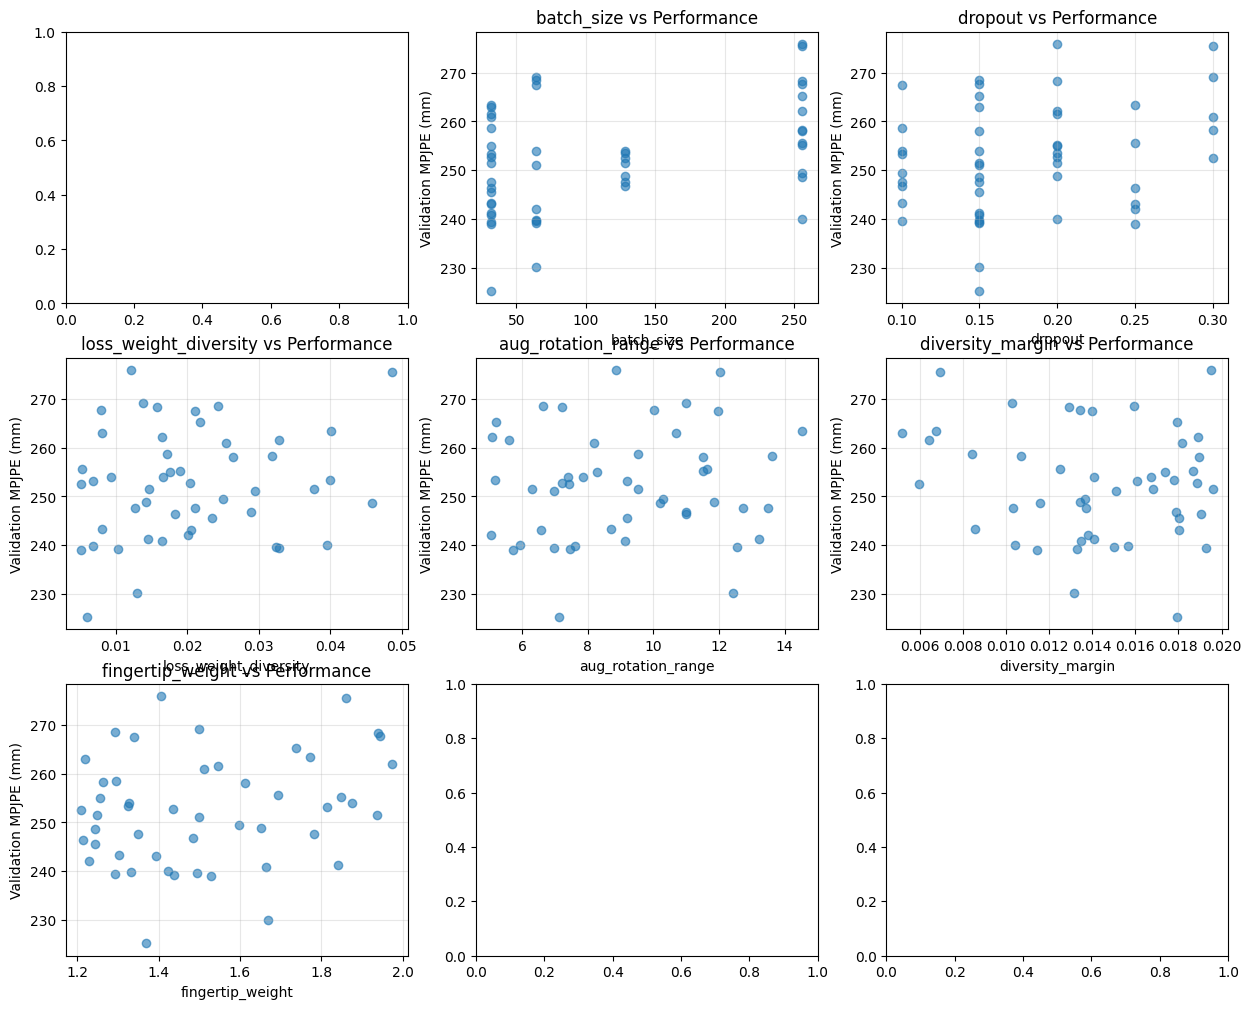

: 

In [7]:
# Visualize parameter importance
import matplotlib.pyplot as plt
import pandas as pd

# Get all runs
runs = sweep.runs
data = []

for run in runs:
    if 'val/hand_mpjpe' in run.summary:
        config = dict(run.config)
        config['val_mpjpe'] = run.summary['val/hand_mpjpe']
        data.append(config)

df = pd.DataFrame(data)

# Plot correlation of key parameters with performance
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

key_params = ['learning_rate', 'batch_size', 'dropout', 'loss_weight_diversity', 
              'aug_rotation_range', 'diversity_margin', 'fingertip_weight',
              'scheduler_type', 'per_joint_weighting']

for i, param in enumerate(key_params):
    if param in df.columns:
        ax = axes[i]
        if param in ['scheduler_type', 'per_joint_weighting']:
            # Categorical parameters
            param_values = df[param].unique()
            mpjpe_by_param = []
            for val in param_values:
                mpjpe_by_param.append(df[df[param] == val]['val_mpjpe'].values)
            ax.boxplot(mpjpe_by_param, labels=param_values)
            ax.set_xlabel(param)
            ax.set_ylabel('Validation MPJPE (mm)')
            ax.set_title(f'{param} vs Performance')
        else:
            # Continuous parameters
            ax.scatter(df[param], df['val_mpjpe'], alpha=0.6)
            ax.set_xlabel(param)
            ax.set_ylabel('Validation MPJPE (mm)')
            ax.set_title(f'{param} vs Performance')
            ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Hyperparameter Impact on Performance', y=1.02)
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Total runs: {len(df)}")
print(f"Best MPJPE: {df['val_mpjpe'].min():.2f} mm")
print(f"Worst MPJPE: {df['val_mpjpe'].max():.2f} mm")
print(f"Mean MPJPE: {df['val_mpjpe'].mean():.2f} mm")
print(f"Std MPJPE: {df['val_mpjpe'].std():.2f} mm")

# Print best batch size analysis
if 'batch_size' in df.columns:
    print("\nBatch Size Analysis:")
    batch_size_stats = df.groupby('batch_size')['val_mpjpe'].agg(['mean', 'std', 'min', 'count'])
    print(batch_size_stats)

## 6. Export Best Configuration

In [ ]:
# Export best configuration for future use
best_config = dict(best_run.config)

# Create optimized configuration file
optimized_config = OmegaConf.load('../configs/default_config.yaml')

# Update with best parameters
optimized_config.training.learning_rate = best_config['learning_rate']
optimized_config.model.dropout = best_config['dropout']

# Update augmentation
optimized_config.data.augmentation.rotation_range = best_config['aug_rotation_range']
optimized_config.data.augmentation.scale_range = [
    best_config['aug_scale_min'],
    best_config['aug_scale_max']
]
optimized_config.data.augmentation.translation_std = best_config['aug_translation_std']
optimized_config.data.augmentation.color_jitter = best_config['aug_color_jitter']
optimized_config.data.augmentation.joint_noise_std = best_config['aug_joint_noise_std']

# Update loss weights
for key in best_config:
    if key.startswith('loss_weight_'):
        loss_key = key.replace('loss_weight_', '')
        optimized_config.loss.loss_weights[loss_key] = best_config[key]

# Update other loss configs
optimized_config.loss.diversity_margin = best_config['diversity_margin']
optimized_config.loss.per_joint_weighting = best_config['per_joint_weighting']
optimized_config.loss.fingertip_weight = best_config['fingertip_weight']

# Save optimized configuration
OmegaConf.save(optimized_config, '../configs/optimized_config.yaml')

print("Optimized configuration saved to configs/optimized_config.yaml")
print("\nYou can now use this configuration for training:")
print("python train_advanced.py --config configs/optimized_config.yaml")

## Summary

This notebook implemented a comprehensive W&B sweep for hyperparameter optimization of the Advanced Manipulation Transformer, focusing on:

1. **Augmentation parameters**: rotation, scale, translation, color jitter, joint noise
2. **Model parameters**: dropout, learning rate
3. **Scheduler options**: cosine, cosine with warmup, step, exponential
4. **Loss weights**: all major loss components
5. **Loss configuration**: diversity margin, per-joint weighting, fingertip weight

The sweep was configured to run each experiment for:
- 7 epochs
- 20,000 training samples
- 2,000 validation samples

Results are automatically tracked in W&B, and the best configuration is exported for future use.